### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchtext
import random 
import math
from torch import zeros
from torchtext.vocab import GloVe
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
from sys import stdout
from json import dumps
from itertools import combinations
from typing import Tuple, Literal, Union
from warnings import filterwarnings
flush, write = stdout.flush , stdout.write
filterwarnings('ignore')

# Corpus

### Dataset download

In [2]:
%%capture
!curl -O https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
!unzip -o dependency_treebank.zip

### Dataset import

In [3]:
#This functions are usefull to import the data from a given range of files

def pad(x, tot_len, pad_val):
  l = len(x)
  return ''.join([pad_val for _ in range(tot_len - l)]) + x

def import_corpus(folder:str, file_base:str, corpus_range:range, separator:str, data:dict):
  keys = list(data.keys())
  data_len = len(keys)
  data['source file'] = []
  for i in corpus_range:
    f = open(f'{folder}/{file_base}{pad(str(i), 4, "0")}.dp')
    for line in f.readlines():
      entry = line.replace('\n','').split(separator)
      if len(entry) >= data_len:
        for j in range(data_len):
            data[keys[j]].append(entry[j])
        data['source file'].append(f'{file_base}{pad(str(i), 4, "0")}')
    f.close()
  return data

In [4]:
SEPARATOR = '\t'
folder = 'dependency_treebank'
file_base = 'wsj_'

train_data = pd.DataFrame(import_corpus(folder, file_base, range(1,101), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
validation_data = pd.DataFrame(import_corpus(folder, file_base, range(101,151), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
test_data = pd.DataFrame(import_corpus(folder, file_base, range(151,200), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
train_data

word/symbol pos label source file
0          Pierre       NNP    wsj_0001
1          Vinken       NNP    wsj_0001
2               ,         ,    wsj_0001
3              61        CD    wsj_0001
4           years       NNS    wsj_0001
...           ...       ...         ...
47351   challenge        NN    wsj_0100
47352          he       PRP    wsj_0100
47353         has       VBZ    wsj_0100
47354       faced       VBN    wsj_0100
47355           .         .    wsj_0100

[47356 rows x 3 columns]

## Data exploration

In [5]:
def add_sum(df:pd.DataFrame, column:str, in_place:bool = True) -> pd.DataFrame:
        if not in_place:
                df = df.copy()
        sums = {}
        for label in np.unique(df[column]):
                sums[label] = df[df[column] == label].count()[column]
        sum_column = []
        for i in range(len(df)):
                sum_column.append(sums[df.iloc[i][column]])
        idx = len(df.columns)
        df.insert(idx, "sum", sum_column, True)
        return df

word/symbol pos label source file
count        47356     47356       47356
unique        8009        45         100
top              ,        NN    wsj_0044
freq          2570      6270        2900

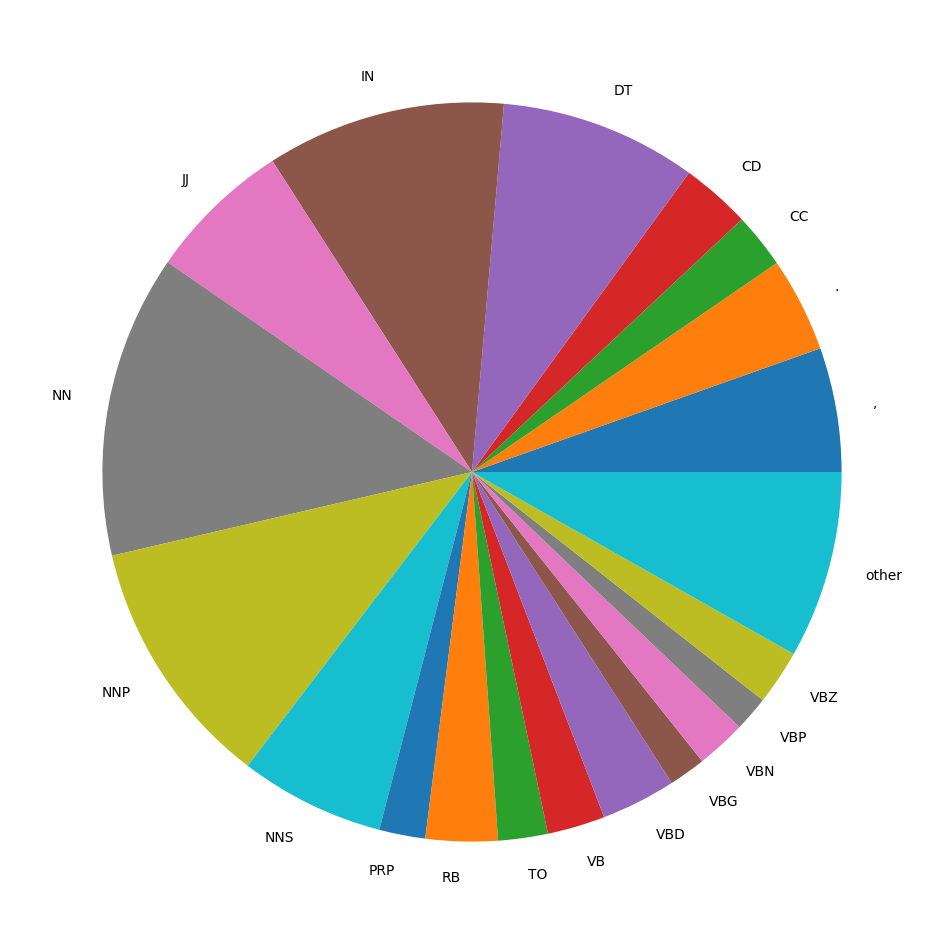

In [6]:
train_plot = train_data.copy()
train_plot = add_sum(train_plot, "pos label")
one_percent = int(len(train_plot) / 100 * 1)
train_plot.loc[train_plot['sum'] < one_percent, 'pos label'] = 'other'
train_plot = train_plot.groupby(['pos label']).size()
train_plot.plot(kind='pie', figsize=(12,12));
train_data.describe()


word/symbol pos label source file
count        31183     31183       31183
unique        5892        44          50
top              ,        NN    wsj_0118
freq          1528      4513        4534

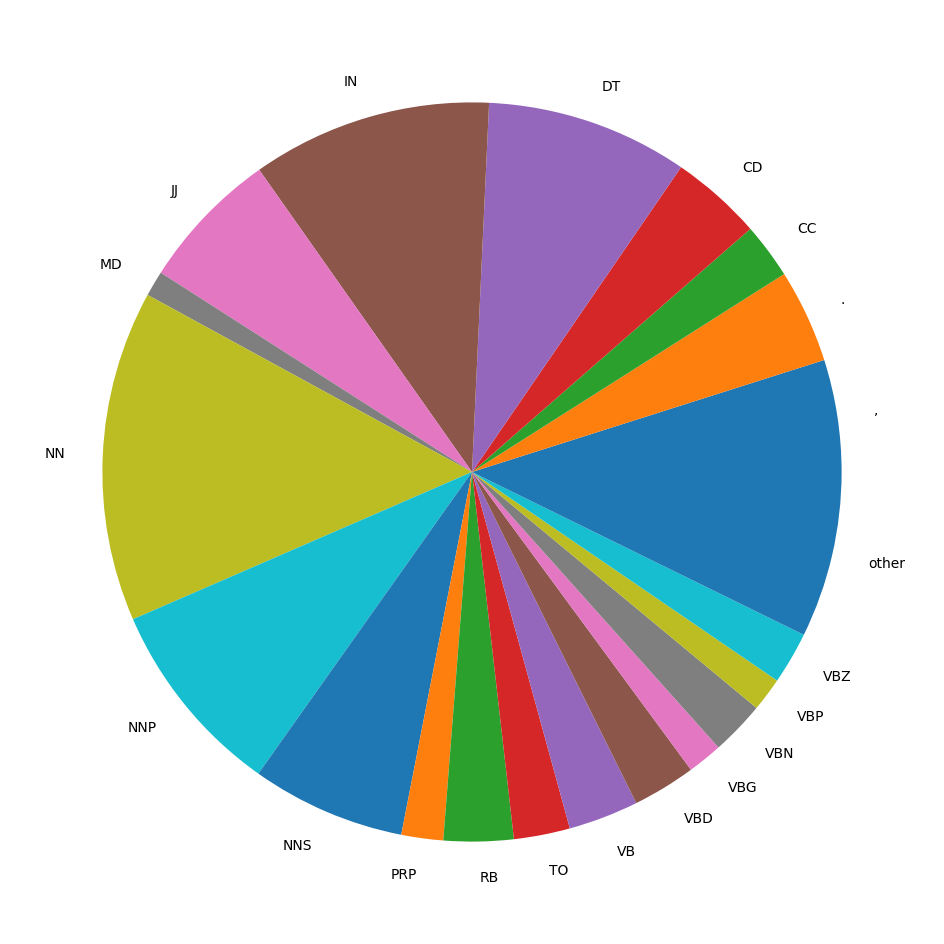

In [7]:
validation_plot = validation_data.copy()
validation_plot = add_sum(validation_plot, "pos label")
one_percent = int(len(validation_plot) / 100 * 1)
validation_plot.loc[validation_plot['sum'] < one_percent, 'pos label'] = 'other'
validation_plot = validation_plot.groupby(['pos label']).size()
validation_plot.plot(kind='pie', figsize=(12,12));
validation_data.describe()

word/symbol pos label source file
count        15545     15545       15545
unique        3623        40          49
top              ,        NN    wsj_0192
freq           787      2383        1492

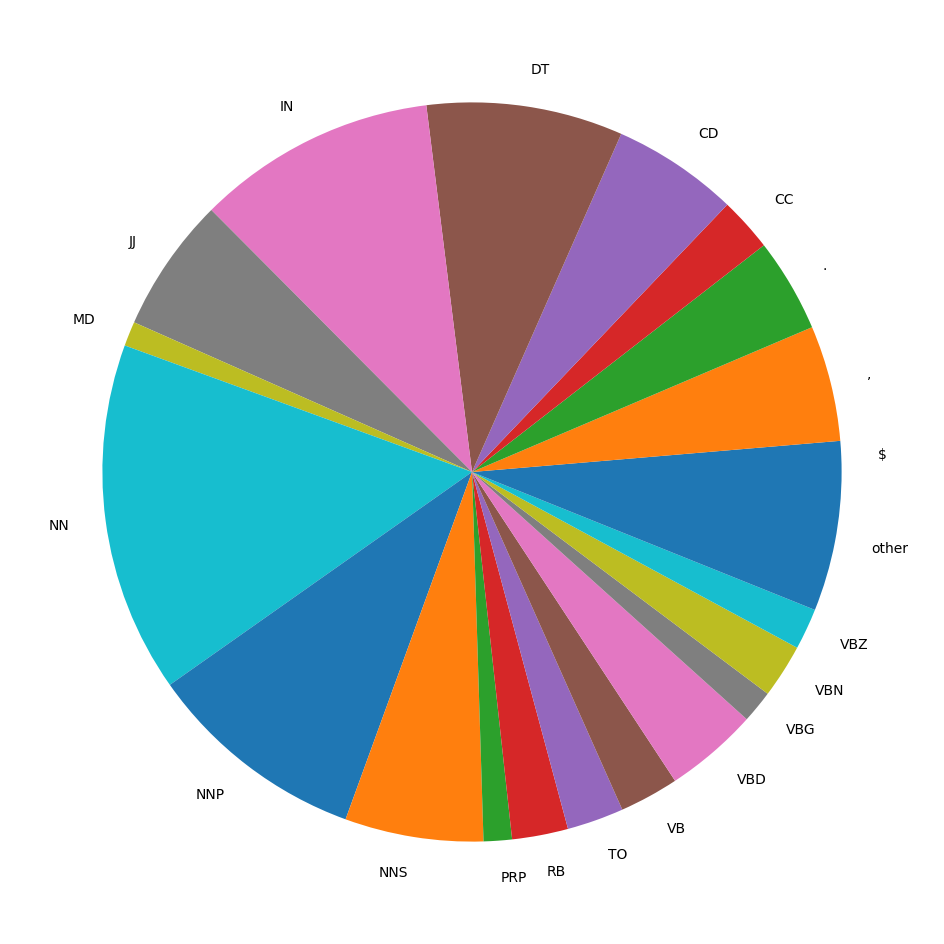

In [8]:
test_plot = test_data.copy()
test_plot = add_sum(test_plot, "pos label")
one_percent = int(len(test_plot) / 100 * 1)
test_plot.loc[test_plot['sum'] < one_percent, 'pos label'] = 'other'
test_plot = test_plot.groupby(['pos label']).size()
test_plot.plot(kind='pie', figsize=(12,12));
test_data.describe()

# Text encoding

In [9]:
EMBEDDING_DIM = 300 #This will be the encoding dimension of our embeddings

In [10]:
#let's download glove
glove = GloVe(name='6B', dim=EMBEDDING_DIM)

Let's explore our embedding:

In [11]:
i = 50
word = train_data.iloc[i]["word/symbol"]
print(f"word at position {i}: {word}")
print(f'embedding: \n {glove[word]}')

word at position 50: director
embedding: 
 tensor([-0.0687, -0.3939,  0.4573, -0.2854,  0.0459, -0.8392, -0.4326, -0.1727,
         0.0622, -0.8511,  0.6977, -0.0665, -0.5244,  0.1738, -0.4251, -0.2834,
         0.1151,  0.0082,  0.2757,  0.3627,  0.1709, -0.0102,  0.3263, -0.2441,
        -0.2870,  1.0194,  0.0812, -0.1947, -0.3475,  0.0832,  0.2689,  0.0258,
         0.2926,  0.5827, -1.1648, -0.1290,  0.2042, -0.3246,  0.1513, -0.3418,
         0.1427, -0.1080,  0.3433,  0.3846, -0.2748, -0.5318, -0.7224,  0.2173,
        -0.3238, -0.2323, -0.3550, -0.0930, -0.0943,  0.2398, -0.1305,  0.4682,
        -0.1757,  0.4127, -0.3832, -0.2612, -0.6611,  0.2374,  0.9375, -0.0258,
         0.0292, -0.0821, -0.2386,  0.0925,  0.2736, -0.6830, -0.2301,  0.4784,
        -0.0183,  0.0266, -0.1814,  0.0901,  0.1913,  0.2784, -0.0887, -0.2237,
        -0.1041,  0.2955,  0.0794,  0.2641,  0.0428,  0.1922, -0.1825,  0.1555,
        -0.1752, -0.4648, -0.3614, -0.1607, -0.3183, -0.1791, -0.2749,  0.154

## Useful classes

### Dataset
it is a usefull class that helps creating a dataloader which is very usefull for training a network since it automatically manages batches

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Vocabulary
It is a class that really helps with managing the words in our dataset. it creates 3 structures:
  - `word2idx` which is a dictionary that maps every word to the corresponding token.
  - `idx2word` which is a list that works as the inverse function to `word2idx` mapping back every token to the corresponding word.
  - `vectors` which is a list that maps every token to the corresponding embedding vector. If no embedding vector has been given for the corresponding word, the vectors list will return a 0 tensor.

In addition, the `length` variable will contains the length of the embedding vectors and `dim` will contains the size of the vocabulary.

In [13]:
class Vocabulary:
  """
  A class containing all the words used in the training.

  Attributes
  ----------
  word2idx : Dict
    Maps every word to the corresponding token.
  idx2word : List[str]
    Works as the inverse function to `word2idx` mapping back every token to the corresponding word.
  vectors : list[torch.Tensor]
    maps every token to the corresponding embedding vector. If no embedding vector has been given for the corresponding word, the vectors list will return a 0 tensor.
  length : int
    contains the length of the embedding vectors.
  dim : int
    contains the size of the vocabulary.
  """
  def __init__(self,
               words:'list[str]',
               pretrained_vectors: 'torchtext.vocab.Vectors' = None,
               specials:'list[str]' = ['<unk>', '<pad>'],
               vectors_length:'int' = -1) -> None:
    """
    Parameters
    ----------
    words: list[str]
      The unique words contained in the vocabulary
    pretrained_vectors: torchtext.vocab.Vectors
      the pretrained embedding containing the Tensors that will be used for the embedding. If there are words included in this class not included in the `words` list they will be added to the vocabulary too.
      It can be None but, in this case, a 0 Tensor will be created for the embedding. In the case this value is None, the `vectors_length` is mandatory.
    specials: list[str]
      A list that contains the special tokens that will be added to the vocabulary. This token will be the first tokens in the resulting list.
    vectors_length: int
      This parameter is mandatory only if the `pretrained_vectors` parameter is None. It represent the length of each Tensor used in the embedding.
    """
    self.__word2idx = {}
    self.idx2word = []
    self.vectors = []

    self.pre_trained = pretrained_vectors != None

    pre_keys = []
    pre_vectors = {}

    if self.pre_trained:
      pre_keys = pretrained_vectors.stoi.keys()
      pre_vectors = pretrained_vectors

    self.length = vectors_length
    if self.pre_trained:
      self.length = len(pretrained_vectors.vectors[0])
      if vectors_length != -1 and self.length != vectors_length:
        raise Exception(f"vectors_length {vectors_length} incompatible with length of pretrained_vectors {self.length}. Consider removing the vector length property")
    if self.length == -1:
      raise Exception("either a the pretrained_vectors or the vectors_length properties should be provided")

    idx = 0

    for word in specials:
      self.__add_word(word, idx, pre_keys, pre_vectors)
      idx += 1

    for word in pre_keys:
      self.__add_word(word, idx, pre_keys, pre_vectors)
      idx += 1

    for word in words:
      if not word in self.__word2idx:
        self.__add_word(word, idx, pre_keys, pre_vectors)
        idx += 1

    self.dim = idx
    self.vectors = torch.stack(self.vectors)

  def word2idx(self, word):
    if word in self.__word2idx:
      return self.__word2idx[word]
    return self.__word2idx['<unk>']

  def __add_word(self, word:'str', idx:'int', pre_keys:'list', pre_vectors: 'dict') -> None:
      self.__word2idx[word] = idx
      self.idx2word.append(word)
      self.vectors.append(pre_vectors[word] if word in pre_keys else zeros(self.length))

In [14]:
vocabulary = Vocabulary(np.unique(train_data['word/symbol']), glove)

Let's explore our vocabulary:

In [15]:
word = 'director'
idx = vocabulary.word2idx('director')
print(f"the index of the word {word} is: {idx}")
print(f"the word of the index {idx} is: {vocabulary.idx2word[idx]}")
print(f"the embedding of the word {word} at index {idx} is:\n\t{vocabulary.vectors[idx]}")

the index of the word director is: 371
the word of the index 371 is: director
the embedding of the word director at index 371 is:
	tensor([-0.0687, -0.3939,  0.4573, -0.2854,  0.0459, -0.8392, -0.4326, -0.1727,
         0.0622, -0.8511,  0.6977, -0.0665, -0.5244,  0.1738, -0.4251, -0.2834,
         0.1151,  0.0082,  0.2757,  0.3627,  0.1709, -0.0102,  0.3263, -0.2441,
        -0.2870,  1.0194,  0.0812, -0.1947, -0.3475,  0.0832,  0.2689,  0.0258,
         0.2926,  0.5827, -1.1648, -0.1290,  0.2042, -0.3246,  0.1513, -0.3418,
         0.1427, -0.1080,  0.3433,  0.3846, -0.2748, -0.5318, -0.7224,  0.2173,
        -0.3238, -0.2323, -0.3550, -0.0930, -0.0943,  0.2398, -0.1305,  0.4682,
        -0.1757,  0.4127, -0.3832, -0.2612, -0.6611,  0.2374,  0.9375, -0.0258,
         0.0292, -0.0821, -0.2386,  0.0925,  0.2736, -0.6830, -0.2301,  0.4784,
        -0.0183,  0.0266, -0.1814,  0.0901,  0.1913,  0.2784, -0.0887, -0.2237,
        -0.1041,  0.2955,  0.0794,  0.2641,  0.0428,  0.1922, -0.1825

## Data pre-processing and preparation

---



### PosEncoding
It is a similar class to Vocabulary but for the position. It works basically the same but with the one-hot-encoding instead of the embedding.

In [16]:
class One_hot_encoder:
  """
  A class containing all the pos values used in the training.

  Attributes
  ----------
  pos2idx : Dict
    Maps every pos to the corresponding token.
  idx2pos : List[str]
    Works as the inverse function to `pos2idx` mapping back every token to the corresponding pos.
  encoding : list[torch.Tensor]
    maps every pos to the corresponding one-hot-encoded vector.
  dim : int
    contains the size of the vocabulary.
  """
  def __init__(self, pos_labels: list[str], specials:list[str] = ['<pad>']) -> None:
    """
    Parameters
    ----------
    pos_labels: list[str]
      The unique words contained in the vocabulary
    specials: list[str]
      A list that contains the special pos that will be added to the vocabulary.
    """
    self.pos2idx = {}
    self.idx2pos = []
    self.encoding = []
    starting_tensor = [0 for _ in range(len(pos_labels) + len(specials))]
    idx = 0

    for pos in specials:
      self.__add_pos(pos, idx, starting_tensor)
      idx += 1

    for pos in pos_labels:
      self.__add_pos(pos, idx, starting_tensor)
      idx += 1


  def __add_pos(self, pos:'str', idx:'int', starting_tensor:'torch.Tensor'):
    self.pos2idx[pos] = idx
    self.idx2pos.append(pos)
    self.encoding.append(starting_tensor.copy())
    self.encoding[idx][idx] = 1


### POS tags encoding

In [17]:
pos_labels = np.unique(train_data['pos label'])
number_of_pos_labels = len(pos_labels)
print(f'there are {number_of_pos_labels} unique pos label values: ' + "\n- " + "\n- ".join(pos_labels))

there are 45 unique pos label values: 
- #
- $
- ''
- ,
- -LRB-
- -RRB-
- .
- :
- CC
- CD
- DT
- EX
- FW
- IN
- JJ
- JJR
- JJS
- LS
- MD
- NN
- NNP
- NNPS
- NNS
- PDT
- POS
- PRP
- PRP$
- RB
- RBR
- RBS
- RP
- SYM
- TO
- UH
- VB
- VBD
- VBG
- VBN
- VBP
- VBZ
- WDT
- WP
- WP$
- WRB
- ``


In [18]:
pos_encoding = One_hot_encoder(pos_labels)

Let's expolore our positional encoding:

In [19]:
pos = 'NNP'
pos_idx = pos_encoding.pos2idx[pos]
print(f'the index of the pos "{pos}" is: {pos_idx}')
print(f'the pos of the index {pos_idx} is: {pos_encoding.idx2pos[pos_idx]}')
print(f'the One HOt Encoding of the pos "{pos}" is:\n\t{pos_encoding.encoding[pos_idx]}')

the index of the pos "NNP" is: 21
the pos of the index 21 is: NNP
the One HOt Encoding of the pos "NNP" is:
	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Data transformation
We need to partition the data into sentences, treating each file as a document for this purpose. However, using each file as a unit of data split may not be optimal, as it could lead to excessively long sentences, adversely affecting the performance of the LSTM. Another drawback to this approach is that it would result in multiple sentences within each row, adding no value to the model while slowing down the inference process.

A more effective strategy is to segment the data based on strong punctuation marks such as "!", "?", ".", and ";". This approach is anticipated to enhance the model's performance. However, a potential downside arises in situations like the following:

```
The cat said: "Meow!" and jumped over the table.
```

Using punctuation-based splitting would yield the following output:

```
["The cat said:\"Meow!\"", "and jumped over the table."]
```
In this case, the punctuation mark "!" incorrectly splits the sentence into two subsentences. 
However, these situations are relatively uncommon and such splits allow to dramatically reduce the length of lots of sentences, improving performances. Therefore, we ultimately decided to split the sentences on said punctuation marks.

In [20]:
def tail_pad(x, tot_len, pad_element):
  l = len(x)
  return x + [pad_element for _ in range(tot_len - l)]

def transform_data(input_data:pd.DataFrame, vocab:Vocabulary, encoding:One_hot_encoder) -> Tuple[torch.Tensor, torch.Tensor]:
  """
    A function that returns a tuple containing two Tensor, the first containg the tokenized words of the dataframe, the second containing the encoded labels of the dataframe.
    Parameters
    ----------
    input_data: pd.Dataframe
      The dataframe containing the data to transform. The value of the words will be checked in the 'word/symbol' column while the label will be cheked in the pos label one. If the sentence_split parameter is false, the elements will be grouped by the source file column.
    vocab: Vocabulary
      The vocabulary used to tokenize the words.
    encoding: PosEncoding
      The encoding of the labels.
    sentence_split: bool
      It tells how to split the sentences: if tru, they will be split by the '.' token, if false they will be split by the source file.
  """
  out_lists_x = [[]]
  out_lists_y = [[]]
  idx = 0
  eos = False
  file = False
  for i in range(input_data.shape[0]):
    row = input_data.iloc[i, :]
    word = row['word/symbol']
    out_lists_x[idx].append(word)
    out_lists_y[idx].append(row['pos label'])
    eos = word == '.' or word == ';' or word == '!' or word == '?'
    next = min(i + 1, input_data.shape[0] - 1)
    file = input_data.iloc[next, :]['source file'] != input_data.iloc[i, :]['source file']
    if eos or file:
      eos = False
      file = False
      out_lists_x.append([])
      out_lists_y.append([])
      idx += 1
  max_len = 0
  if len(out_lists_x[-1]) == 0:
    out_lists_x = out_lists_x[:-1]
    out_lists_y = out_lists_y[:-1]
  for sentence in out_lists_x:
    if len(sentence) > max_len:
      max_len = len(sentence)
  for i in range(len(out_lists_x)):
    out_lists_x[i] = tail_pad(out_lists_x[i], max_len, '<pad>')
    out_lists_y[i] = tail_pad(out_lists_y[i], max_len, '<pad>')
    token_words = []
    for word in out_lists_x[i]:
      token_words.append(vocab.word2idx(word))
    encoded_y = []
    for pos in out_lists_y[i]:
      encoded_y.append(encoding.encoding[encoding.pos2idx[pos]])
    out_lists_x[i] = token_words
    out_lists_y[i] = encoded_y
  return torch.LongTensor(out_lists_x), torch.Tensor(out_lists_y)

In [21]:
x_train, y_train = transform_data(train_data, vocabulary, pos_encoding)
x_validation, y_validation = transform_data(validation_data, vocabulary, pos_encoding)

In [22]:
print(f"shape of train data: {x_train.shape}")

shape of train data: torch.Size([2048, 67])


# Models definition

You are now tasked to define your neural POS tagger.

In [23]:
# first, let's see if there is a gpu available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


## LSTM Layer

A very simple layer. It creates a LSTM that can be used with the `NeuralNetwork` class. It just wrap the [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) class returning only the output value and discarding the internal states

In [24]:
class LSTMLayer(nn.Module):
  """
  A very simple layer. It creates a LSTM that can be used with the `NeuralNetwork` class.
  """
  def __init__(self, input_size:int, hidden_size:int, bidirectional:bool) -> None:
    """
    Parameters
    ----------
    input_size: int
      The size of the input to the LSTM layer.
    hidden_size: int
      The number of LSTM layers.
    bidirectional: bool
      If the LSTM layer are birectional or not.
    """
    super(LSTMLayer, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=bidirectional)

  def forward(self, x):
    out, _ = self.lstm(x)
    return out

## Embed Layer

### Replace embedding
This layer handles the embedding of the tokens. It contains two embedding layers: the first assumes that there are pretrained vectors to use \(vector given as arguments to the `__init__` function\), the second one covers the values that are not present in the pretrained vector. The second embedding layer will be initialized with random values.

The first embedding layer can be frozen in order to avoid training it.

### How the replace Embedding layer works
![img](https://drive.google.com/uc?export=view&id=1tC7yKZwKDkv6RkBK4nU5kz3ckKocnJf4)

In [25]:
class EmbedLayer_replace(nn.Module):
  def __init__(self, vocabulary, embedding_dim):
        super(EmbedLayer_replace, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocabulary.vectors)
        self.oov_embedding = nn.Embedding(vocabulary.dim, embedding_dim)
        nn.init.uniform_(self.oov_embedding.weight, -1.0, 1.0)

  def freeze(self, freeze:'bool'):
    self.embedding.freeze = freeze


  def forward(self, x):
    embedded = self.embedding(x)
    mask = (embedded[:, :, -1] == 0).nonzero()

    embedded[mask[:, 0], mask[:, 1], :] = self.oov_embedding(x[mask[:, 0], mask[:, 1]])
    return embedded


### Sum embedding
This second version of the embedding works a bit differently: It sums the two embedding values instead of replacing the oov words only. The second random embedding should  work as "fine-tuning" layer for training words and be the only embedding for non-pretrained words.

NOTE: When the pretrained layer is freezed, we also do not compute the values from the oov embedding for the tokens available in the pretrained embedding layer. 

### How the sum Embedding layer works
![img](https://drive.google.com/uc?export=view&id=1RrF4tv5YD7gNgjzTJXpeUq3LgQQGAAyH)

In [26]:
class EmbedLayer_sum(nn.Module):
  def __init__(self, vocabulary, embedding_dim):
        super(EmbedLayer_sum, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocabulary.vectors)
        self.oov_embedding = nn.Embedding(vocabulary.dim, embedding_dim)
        self.is_freezed = False
        nn.init.uniform_(self.oov_embedding.weight, -1.0, 1.0)

  def freeze(self, freeze:'bool'):
    self.embedding.freeze = freeze
    self.is_freezed = freeze


  def forward(self, x):
    pre_trained_embedded = self.embedding(x)
    
    if self.is_freezed:
      mask = (pre_trained_embedded[:, :, -1] == 0).nonzero()
      pre_trained_embedded[mask[:, 0], mask[:, 1], :] = self.oov_embedding(x[mask[:, 0], mask[:, 1]])
      return pre_trained_embedded
    
    oov_embeds = self.oov_embedding(x)
    return pre_trained_embedded + oov_embeds

## NeuralNetwork
This class is a really simple class that helps with crating a neural network. It implements a simple training loop that will be available for every class deriving from it.

In [27]:
class NeuralNetwork(nn.Module):
  """
  This class implements a simple interface to get a working neural network using pytorch.
  """
  def __init__(self) -> None:
     super().__init__()

  def train_network(self,
            train_loader:torch.utils.data.DataLoader,
            validation_loader:torch.utils.data.DataLoader,
            optimizer = torch.optim.Adam, 
            loss_function = nn.CrossEntropyLoss(),
            learning_rate:float=.1,
            epochs:int=10,
            device:str='cpu',
            output_extraction_function:callable = lambda x: torch.round(x).detach().cpu(),
            metrics:dict[str,callable] = {},
            verbose:bool=False,
            automatically_handle_gpu_memory:bool = True) -> Tuple[dict[str,list[float]],dict[str,list[float]]]:
    """
      A simple training loop for the neural network. It returns the epochs loss and accuracy history both on the training and the validation set. The tuple will be formatted as:
      train loss, train accuracy, val loss, val accuracy
      Parameters
      ----------
      train_loader: torch.utils.data.DataLoader
        A dataloader containing the dataset that will be used for training the network
      validation_loader: torch.utils.data.DataLoader
        A dataloader containing the dataset that will be used for validate the network at the end of each epoch
      optimizer:
        The optimizer to use while training, default to Adam.
      loss_function:
        The loss function to use while training, default to crossentropy
      learning_rate: float
        The learning rate that will be used in the optimizer to train the network. Default to .1
      epochs:
        The number of training epochs, default to 10.
      device:
        The device to use for the computation
      metrics:
        The metrics to use to evaluate the network
      verbose:
        Determines if intermidiate values of training statistics will be printed to stdout
      automatically_handle_gpu_memory:
        Determines if the training function should handle the moving of the data from e to the gpu memory (both the model and the training/validation data)
    """
    old_device = next(self.parameters()).device
    if next(self.parameters()).device == device or not automatically_handle_gpu_memory:
      net = self
    else:
      net = self.to(device)
    optimizer = optimizer(net.parameters(), learning_rate)

    train_loss_history = []
    val_loss_history = []

    total_batch = int(len(train_loader.dataset) / train_loader.batch_size)
    train_metrics_scores = {}
    val_metrics_scores = {}
    for key in metrics:
        train_metrics_scores[key] = []
        val_metrics_scores[key] = []

    for epoch in range(epochs):
        net.train()
        for batch_idx, data in enumerate(train_loader):
            labels = data[1]
            inputs = data[0]
            if automatically_handle_gpu_memory:
              labels = data[1].to(device)
              inputs = self.__to(data[0], device)
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            predicted_classes = output_extraction_function(outputs)
            normal_labels = output_extraction_function(labels)
            if verbose:
              stdout.write(f"\rbatch {batch_idx + 1}/{total_batch} ----- loss: {loss.cpu()} ----- {'-----'.join([f'{key}: {metrics[key](predicted_classes, normal_labels)}' for key in metrics.keys()])}")
              stdout.flush()
            if automatically_handle_gpu_memory:
              self.__remove(inputs)
              del labels
              torch.cuda.empty_cache()

        val_metrics, val_loss = self.__validate(validation_loader, metrics, loss_function, device, output_extraction_function, automatically_handle_gpu_memory)
        for key in metrics:
          val_metrics_scores[key].append(val_metrics[key])
        val_loss_history.append(val_loss)
        train_metrics, train_loss = self.__validate(train_loader, metrics, loss_function, device, output_extraction_function, automatically_handle_gpu_memory)
        for key in metrics:
          train_metrics_scores[key].append(train_metrics[key])
        train_loss_history.append(train_loss)
        if verbose:
          out_str = f"EPOCH {epoch + 1} training loss: {train_loss_history[-1]} - validation loss: {val_loss_history[-1]}\n" + \
          '\n'.join([f"EPOCH {epoch + 1} training {metric}: {train_metrics_scores[metric][-1]} - validation {metric}: {val_metrics_scores[metric][-1]}" for metric in metrics.keys()]) +\
          f"\n{'-'*100}\n"
          stdout.write("\r" + " " * len(out_str) + "\r")
          stdout.flush()
          stdout.write(out_str)
          stdout.flush()
          print()
    train_metrics_scores['loss'] = train_loss_history
    val_metrics_scores['loss'] = val_loss_history

    if next(self.parameters()).device != old_device and automatically_handle_gpu_memory:
      del net
      self = self.to(old_device)
      torch.cuda.empty_cache()

    return train_metrics_scores, val_metrics_scores
  
  def __to(self, data, device):
    if isinstance(data, dict):
      return {key: self.__to(data[key], device) for key in data.keys()}
    elif isinstance(data, list):
      return [self.__to(d, device) for d in data]
    elif isinstance(data, tuple):
      return tuple([self.__to(d, device) for d in data])
    else:
      return data.to(device)
    
  def __remove(self, data):
    if isinstance(data, dict):
      for key in data.keys():
        self.__remove(data[key])
    elif isinstance(data, list) or isinstance(data, tuple):
      for d in data:
        self.__remove(d)
    else:
      del data

  def __validate(self, loader, metrics, loss_function, device, output_extraction_function, automatically_handle_gpu_memory):
    losses = []
    metrics_scores = {}
    for key in metrics.keys():
      metrics_scores[key] = []
    net = self.to(device)
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
          labels = data[1]
          inputs = data[0]
          if automatically_handle_gpu_memory:
            inputs = self.__to(data[0], device)
            labels = data[1].to(device)
          outputs = net(inputs)
          loss = loss_function(outputs, labels)
          losses.append(loss)
          predicted_classes = output_extraction_function(outputs)
          real_labels = output_extraction_function(labels)
          for key in metrics.keys():
            metrics_scores[key].append(metrics[key](predicted_classes, real_labels))
          if automatically_handle_gpu_memory:
            self.__remove(inputs)
            del labels
            torch.cuda.empty_cache()

    average_loss = sum(losses)/(batch_idx+1)
    mean_metrics_scores = {}
    for key in metrics.keys():
      mean_metrics_scores[key] = sum(metrics_scores[key])/len(loader)
    return mean_metrics_scores, average_loss


### Model definitions

In [28]:
#hyper-paramters constants
OUTPUT_SIZE = y_train.shape[2]

In [29]:
class Baseline(NeuralNetwork):
    def __init__(self, 
                encoding_dimension:int, 
                lstm_hidden_size:int, 
                out_shape:int, 
                lstm_bilateral:bool = True,
                embedding_type:Literal["Replace","Sum"] = 'Replace'
                ):
        super().__init__()
        embed_layer = {
            'Replace': EmbedLayer_replace,
            'Sum':EmbedLayer_sum
        }
        self.embedding = embed_layer[embedding_type](vocabulary, encoding_dimension)
        self.lstm = LSTMLayer(encoding_dimension, lstm_hidden_size, lstm_bilateral)
        self.linear = nn.Linear(lstm_hidden_size * 2, out_shape)

    def forward(self, x):
        embedded_input = self.embedding(x)
        lstm_out = self.lstm(embedded_input)
        out = self.linear(lstm_out)
        return out
    

class Model1(NeuralNetwork):
    def __init__(self, 
                encoding_dimension:int, 
                lstm_hidden_size:int, 
                out_shape:int, 
                lstm_bilateral:bool = True,
                embedding_type:Literal["Replace","Sum"] = 'Replace'
                ):
        super().__init__()
        embed_layer = {
            'Replace': EmbedLayer_replace,
            'Sum':EmbedLayer_sum
        }
        self.embedding = embed_layer[embedding_type](vocabulary, encoding_dimension)
        self.first_lstm = LSTMLayer(encoding_dimension, lstm_hidden_size, lstm_bilateral)
        self.second_lstm = LSTMLayer(lstm_hidden_size * 2, lstm_hidden_size, lstm_bilateral)
        self.linear = nn.Linear(lstm_hidden_size * 2, out_shape)

    def forward(self, x):
        embedded_input = self.embedding(x)
        first_lstm_out = self.first_lstm(embedded_input)
        second_lstm_out = self.second_lstm(first_lstm_out)
        out = self.linear(second_lstm_out)
        return out

class Model2(NeuralNetwork):
    def __init__(self, 
                encoding_dimension:int, 
                lstm_hidden_size:int, 
                out_shape:int, 
                linear_size:int, 
                lstm_bilateral:bool = True,                
                embedding_type:Literal["Replace","Sum"] = 'Replace'
                ):
        super().__init__()
        embed_layer = {
            'Replace': EmbedLayer_replace,
            'Sum':EmbedLayer_sum
        }
        self.embedding = embed_layer[embedding_type](vocabulary, encoding_dimension)
        self.lstm = LSTMLayer(encoding_dimension, lstm_hidden_size, lstm_bilateral)
        self.first_linear = nn.Linear(lstm_hidden_size * 2, linear_size)
        self.relu = nn.ReLU()
        self.second_linear = nn.Linear(linear_size, out_shape)

    def forward(self, x):
        embedded_input = self.embedding(x)
        lstm_out = self.lstm(embedded_input)
        linear_out = self.first_linear(lstm_out)
        linear_out = self.relu(linear_out)
        out = self.second_linear(linear_out)
        return out

# [Task 4 - 1.0 points] Metrics

Let's see what can be cosidered as 'punctuation':

In [30]:
print(pos_encoding.pos2idx["#"])
print(pos_encoding.pos2idx["$"])
print(pos_encoding.pos2idx["''"])
print(pos_encoding.pos2idx[','])
print(pos_encoding.pos2idx['.'])
print(pos_encoding.pos2idx[':'])
print(pos_encoding.pos2idx['``'])

1
2
3
4
7
8
45


In [31]:
def mask(y_1, y_2):
  exclude_values = torch.Tensor([pos_encoding.pos2idx['<pad>'],
                    pos_encoding.pos2idx["''"],
                    pos_encoding.pos2idx[','],                    
                    pos_encoding.pos2idx["$"],
                    pos_encoding.pos2idx["#"],
                    pos_encoding.pos2idx['.'],
                    pos_encoding.pos2idx[':'],
                    pos_encoding.pos2idx['``']])
  idx_to_use = torch.isin(y_2, exclude_values, invert=True)
  return y_1[idx_to_use], y_2[idx_to_use]

def masked_accuracy(best_guesses, targets):
  actual_best_guesses, actual_targets = mask(best_guesses, targets)
  correct_percentage = accuracy_score(actual_targets,actual_best_guesses)
  return correct_percentage

def masked_recall(best_guesses, targets):
  actual_best_guesses, actual_targets = mask(best_guesses, targets)
  correct_percentage = recall_score(actual_targets,actual_best_guesses, average='macro')
  return correct_percentage

def masked_precision(best_guesses, targets):
  actual_best_guesses, actual_targets = mask(best_guesses, targets)
  correct_percentage = precision_score(actual_targets,actual_best_guesses, average='macro')
  return correct_percentage

def calculate_metrics(y_true, y_pred):
    tp = torch.sum((y_true == 1) & (y_pred == 1)).item()
    fp = torch.sum((y_true == 0) & (y_pred == 1)).item()
    fn = torch.sum((y_true == 1) & (y_pred == 0)).item()
    tn = torch.sum((y_true == 0) & (y_pred == 0)).item()

    return tp, fp, fn, tn


def calculate_precision_recall_f1(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1


def masked_f1_score(y_true, y_pred):

  y_pred, y_true = mask(y_pred, y_true)

  unique_classes = torch.unique(torch.cat([y_true, y_pred]))

  precision_list, recall_list, f1_list = [], [], []

  for cls in unique_classes:
      true_cls = torch.where(y_true == cls, 1, 0)
      pred_cls = torch.where(y_pred == cls, 1, 0)

      tp, fp, fn, _ = calculate_metrics(true_cls, pred_cls)
      precision, recall, f1 = calculate_precision_recall_f1(tp, fp, fn)

      precision_list.append(precision)
      recall_list.append(recall)
      f1_list.append(f1)

  macro_avg_f1 = sum(f1_list) / max(len(f1_list),1)

  return macro_avg_f1

# Training and Evaluation

In [32]:
BATCH_SIZE = 64
train_dataset = Dataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

validation_dataset = Dataset(x_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
def compute_frequecies():
  frequencies = [train_data[train_data['pos label'] == name]['pos label'].count() for name in pos_encoding.pos2idx.keys()]
  max_freq = max(frequencies)
  min_freq = min(frequencies)
  norm_factor = max_freq - min_freq
  weights = [1 + ((max_freq - freq)/norm_factor) for freq in frequencies]
  weights[pos_encoding.pos2idx['<pad>']] = 0
  return torch.Tensor(weights)
weights = compute_frequecies()
weights = weights.to(device)

In [34]:
def greedy_train(
        model_parameters:list[dict], 
        train_parameters:dict, 
        model_class:NeuralNetwork, 
        seeds:list[int], 
        save_file:'str|None' = None, 
        training_loop:'callable|None' = None,
        save_weigths:bool = False,
        delete_network:bool = True):
    """
    A function that trains a neural network model given on each parameter passed using the training parameter passed as input.

    Parameters
    ----------
    model_parameters : list[dict]
        A list of dictionaries where each dictionary contains the specific parameters for configuring the model.

    train_parameters : dict
        A dictionary containing parameters for training the model. This could include hyperparameters, optimization settings, etc.

    model_class : NeuralNetwork
        The class of the neural network model to be trained. This should be a class that implements the desired neural network architecture.

    seeds : list[int]
        A list of random seeds to ensure reproducibility. Each seed corresponds to a different run of the training process.

    save_file : str|None, optional
        the file where to save the output dict. If None, the output won't be saved. Default is None.

    training_loop : callable|None, optional
        A callable function that defines a custom training loop. If None, the default training loop provided by the model_class is used. Default is None.

    save_weights : bool, optional
        A flag indicating whether to save the weights during training. If True, the weights are saved in a file called model_name + seed. Default is False.

    delete_network : bool, optional
        A flag indicating whether to delete the neural network instance after training. If True, the neural network instance is deleted to free up memory. Default is True.

    Returns
    -------
    list[dict]
        A list of dictionaries containing information about the training process for each run with different seeds. Each dictionary includes details such as training loss, validation metrics, etc.
    """
    results = []
    for seed in tqdm(seeds, desc='seeds'):
        for param in tqdm(model_parameters, desc='parameters', leave=False):
            res = param.copy()
            name = res['name']
            del res['name']
            random.seed(seed)
            torch.manual_seed(seed)
            model = model_class(**res)
            if training_loop is None:
                train_score, val_score = model.train_network(**train_parameters)
            else: 
                train_score, val_score = training_loop(model, train_parameters)
            for key in train_score:
                train_score[key] = [float(v) for v in train_score[key]]
                val_score[key] = [float(v) for v in val_score[key]]
            res['train_score'] = train_score
            res['val_score'] = val_score
            res['name'] = name
            res['seed'] = seed
            results.append(res)
            if save_weigths:
                torch.save(model.state_dict(), name + " " + seed)
            if delete_network:
                del model
                torch.cuda.empty_cache()


    if not save_file is None:
        f = open(save_file,'w')
        f.write(dumps(results))
        f.close()
    return results

In [35]:
class Custom_crossentropy(nn.CrossEntropyLoss):
    """
    A class usefull to use with the NeuralNetwork class that implements a custom crossentropyLoss that automatically handles the reshape of the input tensors.
    """
    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        n_batch, n_sequence, n_classes = input.shape
        loss_input = torch.reshape(input, (n_batch, n_classes, n_sequence))
        loss_target = torch.reshape(target, (n_batch, n_classes, n_sequence))
        return super().forward(loss_input, loss_target)

In [36]:
TRAINING_PARAMETERS = {
    'train_loader':train_loader, 
    'validation_loader':validation_loader,
    'device':device, 
    'loss_function':Custom_crossentropy(weights), 
    'metrics':{'accuracy':masked_accuracy, 'f1':masked_f1_score, 'recall': masked_recall, 'precision': masked_precision},
    'learning_rate':.001,
    'output_extraction_function':lambda x: torch.max(x, -1)[1].view(-1).cpu(),
    'epochs':20,
    'verbose':False
}
SEEDS = [42, 25, 74] 

In [38]:
baseline_parameters = [
    {
        'name':'baseline_100_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'baseline_200_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'baseline_100_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    },
    {
        'name':'baseline_200_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    }
] 
results_baseline = greedy_train(baseline_parameters, TRAINING_PARAMETERS, Baseline, SEEDS, "baseline.json")

seeds: 100%|██████████| 3/3 [06:48<00:00, 136.00s/it]


In [39]:
model1_parameters = [
    {
        'name':'model1_75_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':75,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'model1_200_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'model1_75_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':75,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    },
    {
        'name':'model1_200_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    }
] 
results_model1 = greedy_train(model1_parameters, TRAINING_PARAMETERS, Model1, SEEDS, "model1.json")

seeds: 100%|██████████| 3/3 [06:43<00:00, 134.43s/it]


In [40]:
model2_parameters = [
    {
        'name':'model2_150_100_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':150,
        'linear_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'model2_200_50_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'linear_size':50,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'model2_150_100_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':150,
        'linear_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    },
    {
        'name':'model2_200_50_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'linear_size':50,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    }
] 
results_model2 = greedy_train(model2_parameters, TRAINING_PARAMETERS, Model2, SEEDS, "model2.json")

seeds: 100%|██████████| 3/3 [08:07<00:00, 162.42s/it]


## Evaluation

In [37]:
def plot_dictionary_lines(data_dict, x_label, x_multiplier = 6, y_multiplier = 6):
    """
    Plot multiple lines from a dictionary of data on a single figure with subplots.

    Parameters
    ----------
    data_dict : dict
        A dictionary where keys represent plot names, and values are dictionaries mapping line names to their corresponding values.
        Example:
        {
            'Plot1': {'Line1': [val1, val2, ...], 'Line2': [val1, val2, ...]},
            'Plot2': {'Line1': [val1, val2, ...], 'Line2': [val1, val2, ...]},
            ...
        }

    x_label : str
        The label for the x-axis.

    x_multiplier : int, optional
        Multiplier for the width of each subplot. Default is 6.

    y_multiplier : int, optional
        Multiplier for the height of each subplot. Default is 6.

    Returns
    -------
    None
        The function displays the generated plot.

    Notes
    -----
    - The function creates subplots for each plot in the data_dict.
    - Each subplot contains lines corresponding to the line names in the plot's data.
    - The x-axis is labeled with x_label.
    - The y-axis is labeled with the plot name followed by 'values'.
    - Legends are displayed for each subplot.
    - The function uses matplotlib for plotting and adjusts the layout for a clean presentation.

    Example
    -------
    >>> data = {
    ...     'Training': {'Loss': [0.5, 0.4, 0.3], 'Accuracy': [0.8, 0.85, 0.9]},
    ...     'Validation': {'Loss': [1.0, 0.9, 0.8], 'Accuracy': [0.7, 0.75, 0.8]}
    ... }
    >>> plot_dictionary_lines(data, x_label='Epochs')
    """
    plot_names = list(data_dict.keys())

    num_plots = len(plot_names)
    num_plots = len(plot_names)
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))

    _, axs = plt.subplots(num_cols, num_rows, figsize=(y_multiplier * num_cols, x_multiplier * num_rows), sharex=True)
    axs = np.ravel(axs) if num_plots > 1 else [axs]

    for i, (plot_name, plot_data) in enumerate(data_dict.items()):

        for line_name, line_values in plot_data.items():
            axs[i].plot(line_values, label=line_name)

        
        axs[i].set_title(plot_name)
        axs[i].legend()
        axs[i].set_ylabel(f'{plot_name} values') 

    plt.xlabel(x_label)
    plt.tight_layout()
    plt.show()

In [38]:
def plot_with_differences(model_names:list[str], plot_names:list[str], model_training_data:list[dict]) -> Tuple[list[dict[str, dict[str, list[float]]]], pd.DataFrame]:
    """
    Compute and visualize differences in training and validation scores among combinations of models.

    Parameters
    ----------
    model_names : List[str]
        A list of model names to analyze.

    plot_names : List[str]
        A list of plot names representing different metrics to compare.

    model_training_data : List[Dict]
        A list of training data to transform
    Returns
    -------
    Tuple[Dict[str, Dict[str, List[float]]], pd.DataFrame]
        A tuple containing two elements:
        1. A dictionary where keys are combinations of model and plot names, and values are dictionaries containing training and validation scores.
           Example:
           {
               'Model1 Metric1': {'seed1 training score': [val1, val2, ...], 'seed1_Model1 validation score': [val1, val2, ...], ...},
               'Model1 Metric2': {'seed1 training score': [val1, val2, ...], 'seed1_Model1 validation score': [val1, val2, ...], ...},
               ...
           }
        2. A pandas DataFrame containing differences in mean, max, and min training/validation scores among model combinations.
           Columns: 'model_name', 'metric', 'mean_train_difference', 'max_train_difference', 'min_train_difference',
                    'mean_val_difference', 'max_val_difference', 'min_val_difference'.

    Notes
    -----
    - The function computes differences in scores among all combinations of models for each specified metric.
    - The result is returned in a dictionary suitable for plotting and a DataFrame for statistical analysis.
    - The function uses itertools.combinations to generate model pairs for comparison.

    Example
    -------
    >>> models = ['Model1', 'Model2', 'Model3']
    >>> metrics = ['Accuracy', 'Loss']
    >>> plots, differences_df = plot_with_differences(models, metrics)
    """
    plots = {}
    difference = []
    for name in model_names:
        for plot_name in plot_names:   
            all_models = all(model_training_data, lambda e: e['name'] == name)
            _range = range(len(all_models[0]['train_score'][plot_name]))
            t_diff = [np.abs(m[0]['train_score'][plot_name][i] - m[1]['train_score'][plot_name][i]) for m in combinations(all_models,2) for i in _range]
            v_diff = [np.abs(m[0]['val_score'][plot_name][i] - m[1]['val_score'][plot_name][i]) for m in combinations(all_models,2) for i in _range]
            difference.append({
                'model_name':name,
                'metric':plot_name,
                'mean_train_difference': np.mean(t_diff),
                'max_train_difference': max(t_diff),
                'min_train_difference': min(t_diff),
                'mean_val_difference': np.mean(v_diff),
                'max_val_difference': max(v_diff),
                'min_val_difference': min(v_diff),
            })
            plots[name + ' ' + plot_name] = {f'{model["seed"]} training score': model['train_score'][plot_name] for model in all_models}
            plots[name + ' ' + plot_name].update({f'{model["seed"]}_{name} validation score': model['val_score'][plot_name] for model in all_models})
    return plots, pd.DataFrame(difference)

In [39]:
def get_plots(training_data:list[dict], seed:int, plot_names:list[str]) -> dict:
    """
    Extract training and validation scores for specified plot names from training data.

    Parameters
    ----------
    training_data : List[dict]
        A list of dictionaries containing training and validation scores for different models.

    seed : int
        The seed value to filter training data for a specific run.

    plot_names : List[str]
        A list of plot names to extract scores for.

    Returns
    -------
    Dict[str, Dict[str, List[float]]]
        A dictionary where keys represent plot names and training/validation, and values are dictionaries containing scores for each specified model.
        Example:
        {
            'Metric1 training': {'Model1': [val1, val2, ...], 'Model2': [val1, val2, ...], ...},
            'Metric1 validation': {'Model1': [val1, val2, ...], 'Model2': [val1, val2, ...], ...},
            'Metric2 training': {'Model1': [val1, val2, ...], 'Model2': [val1, val2, ...], ...},
            'Metric2 validation': {'Model1': [val1, val2, ...], 'Model2': [val1, val2, ...], ...},
            ...
        }

    Notes
    -----
    - The function extracts training and validation scores for specified plot names from the provided training data.
    - Scores are organized into a dictionary suitable for plotting or further analysis.

    Example
    -------
    >>> data = [
    ...     {'name': 'Model1', 'seed': 1, 'train_score': {'Accuracy': [0.8, 0.85, 0.9], 'Loss': [0.2, 0.15, 0.1]}, 'val_score': {...}},
    ...     {'name': 'Model2', 'seed': 1, 'train_score': {'Accuracy': [0.7, 0.75, 0.8], 'Loss': [0.3, 0.25, 0.2]}, 'val_score': {...}},
    ...     ...
    ... ]
    >>> seed_value = 1
    >>> metrics_to_extract = ['Accuracy', 'Loss']
    >>> extracted_plots = get_plots(data, seed_value, metrics_to_extract)
    """
    plots = {}
    all_models = all(training_data, lambda e: e['seed'] == seed)
    for plot_name in plot_names:
        train = {}
        val = {}
        for model in all_models:
            for key in model["train_score"].keys():
                if plot_name in key:
                    name = key.replace(plot_name, "") if len(key) != len(plot_name) else plot_name
                    train[f'{model["name"]} {name}'] = model['train_score'][key]
                    val[f'{model["name"]} {name}'] = model['val_score'][key]
        plots[plot_name + ' training'] = train
        plots[plot_name + ' validation']= val
    return plots

In [40]:
def unique(l:list, func:callable) -> list:
    """
    apply the function func to each element of l and returns it's unique values
    """
    values = [func(e) for e in l]
    return list(np.unique(values))

def all(l:list, func:callable) -> list:
    """
    returns every element of the list l if the element satisfy the condition computed by the function func
    """
    all_vals = []
    for e in l:
        if func(e):
            all_vals.append(e)
    return all_vals

## Training statistics differences per seed

### Baseline

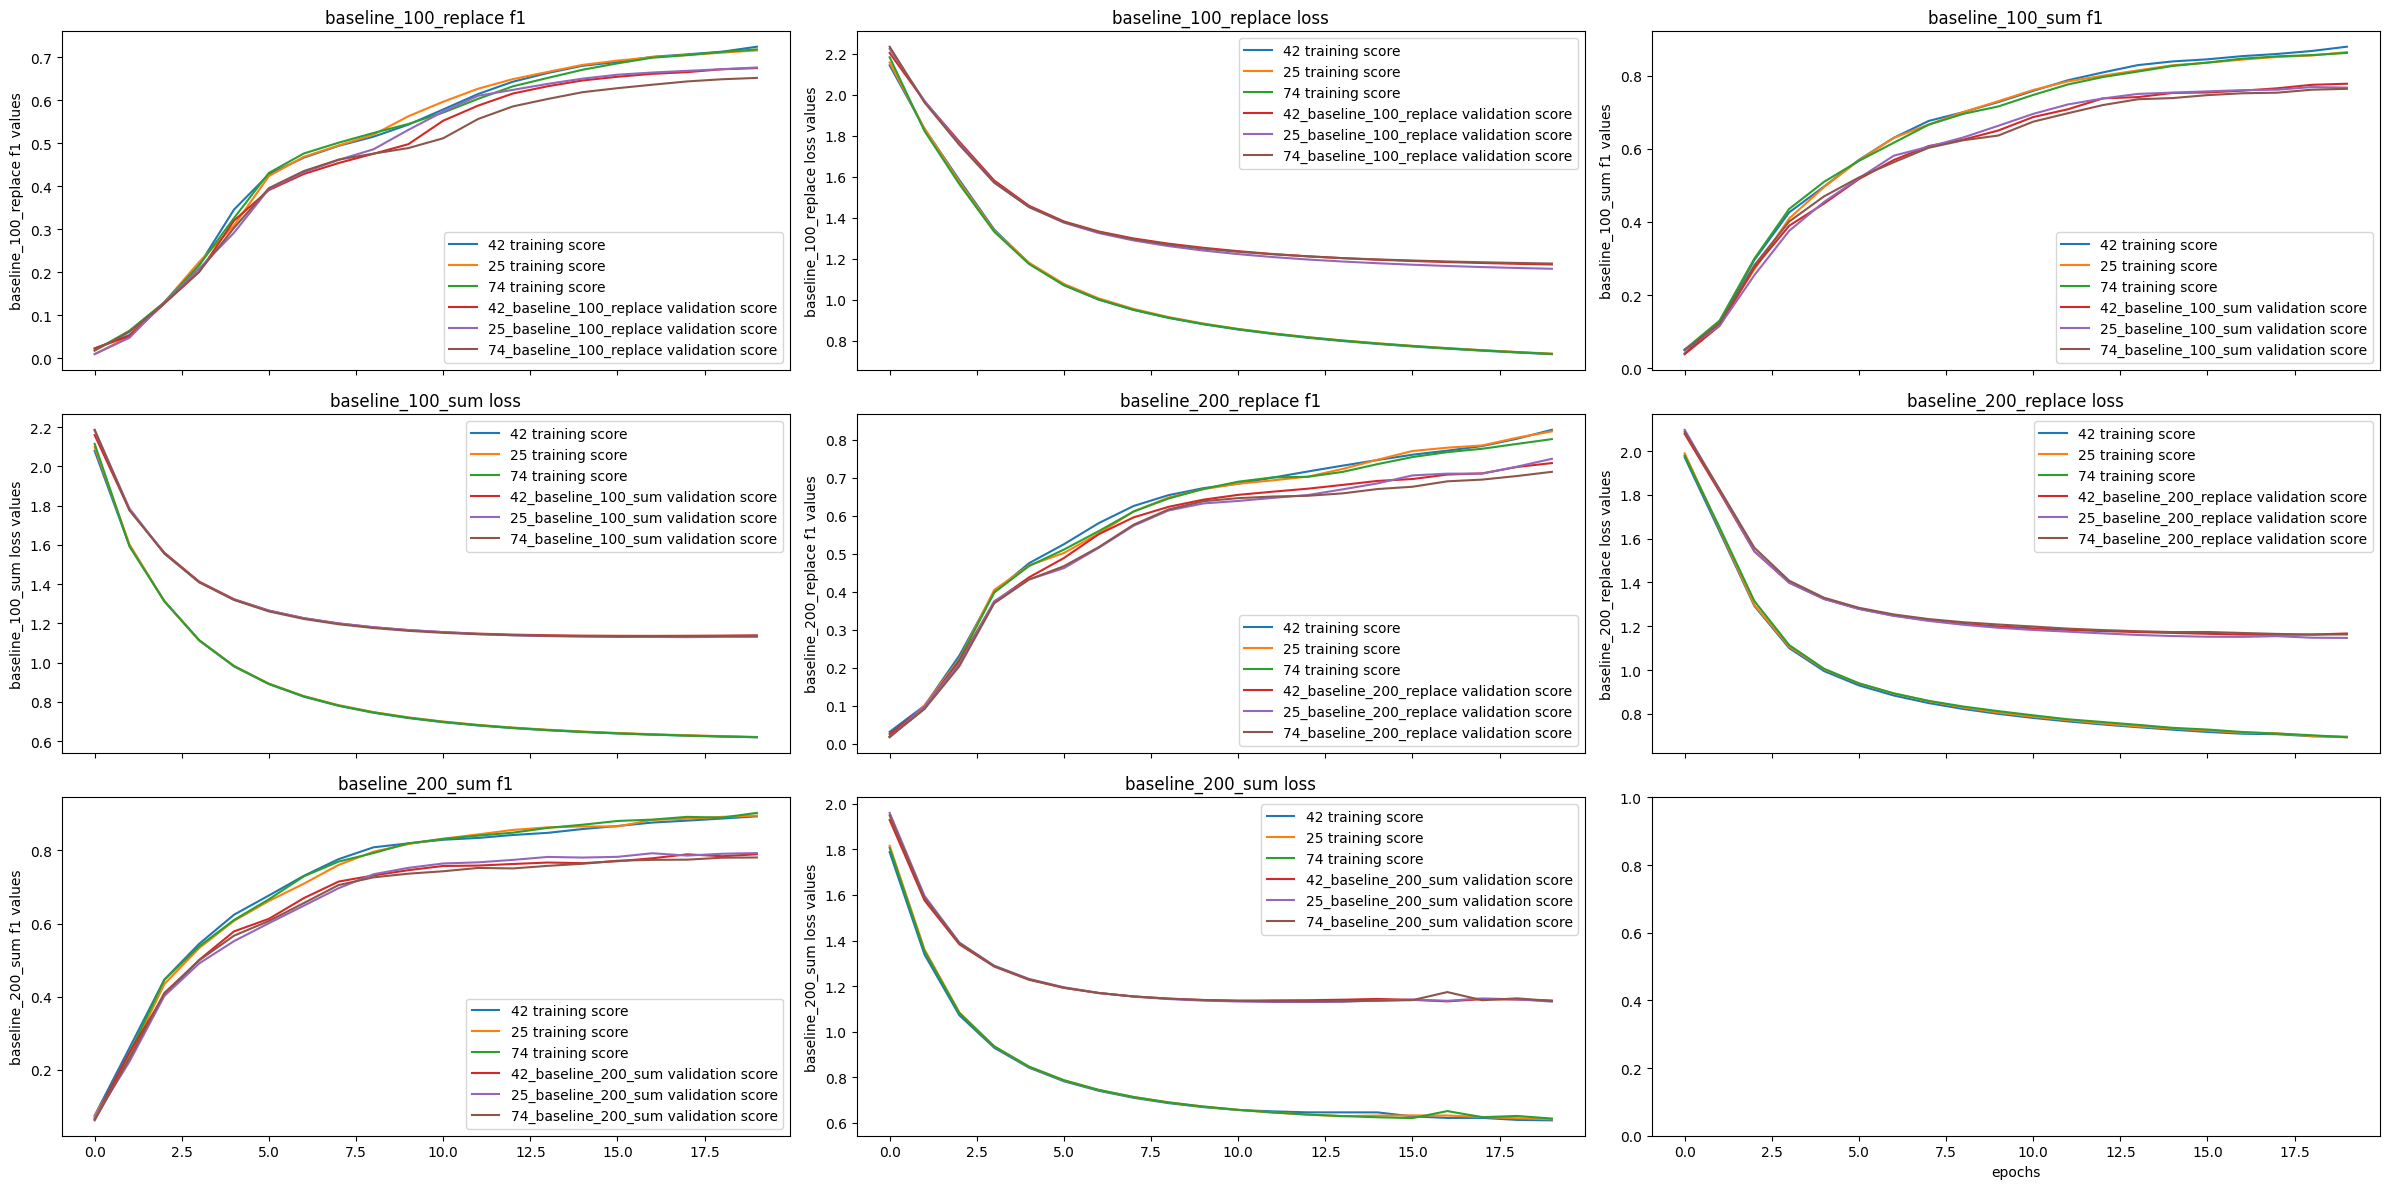

model_name metric  mean_train_difference  max_train_difference  \
0  baseline_100_replace     f1               0.007932              0.036841   
1  baseline_100_replace   loss               0.004693              0.039284   
2      baseline_100_sum     f1               0.008568              0.029419   
3      baseline_100_sum   loss               0.003021              0.036086   
4  baseline_200_replace     f1               0.008506              0.027450   
5  baseline_200_replace   loss               0.007248              0.022471   
6      baseline_200_sum     f1               0.008152              0.024141   
7      baseline_200_sum   loss               0.007181              0.030044   

   min_train_difference  mean_val_difference  max_val_difference  \
0              0.000091             0.016363            0.061849   
1              0.000120             0.010514            0.030405   
2              0.000123             0.010143            0.027276   
3              0.000235             0.003983            0.026701   
4              0.000222             0.012104            0.035791   
5              0.000153             0.009125            0.021624   
6              0.000196             0.010715            0.026701   
7              0.000023             0.005766            0.040851   

   min_val_difference  
0            0.000040  
1            0.000067  
2            0.000053  
3            0.000191  
4            0.000364  
5            0.000276  
6            0.001205  
7            0.000113

In [45]:
model_names = unique(results_baseline, lambda e: e['name'])
plots, differences = plot_with_differences(model_names, ["f1", "loss"], results_baseline)
plot_dictionary_lines(plots, 'epochs', x_multiplier=4, y_multiplier=8)
differences

### Model 1

In [46]:
model_names = unique(results_model1, lambda e: e['name'])
plots, differences = plot_with_differences(model_names, ["f1", "loss"], results_model1)
plot_dictionary_lines(plots, 'epochs', x_multiplier=4, y_multiplier=8)
differences

model_name metric  mean_train_difference  max_train_difference  \
0  model1_200_replace     f1               0.013831              0.046638   
1  model1_200_replace   loss               0.014429              0.095268   
2      model1_200_sum     f1               0.018279              0.076562   
3      model1_200_sum   loss               0.015421              0.109674   
4   model1_75_replace     f1               0.014768              0.051663   
5   model1_75_replace   loss               0.013289              0.093933   
6       model1_75_sum     f1               0.012573              0.047837   
7       model1_75_sum   loss               0.013115              0.085789   

   min_train_difference  mean_val_difference  max_val_difference  \
0              0.000107             0.016399            0.054383   
1              0.002413             0.013323            0.081267   
2              0.000688             0.013673            0.072150   
3              0.000244             0.012629            0.098163   
4              0.000094             0.014710            0.062343   
5              0.000367             0.021741            0.088711   
6              0.000127             0.011151            0.044848   
7              0.000105             0.019717            0.082314   

   min_val_difference  
0            0.000632  
1            0.000095  
2            0.000151  
3            0.000324  
4            0.000254  
5            0.000106  
6            0.000281  
7            0.000092

### Model 2

In [47]:
model_names = unique(results_model2, lambda e: e['name'])
plots, differences = plot_with_differences(model_names, ["f1", "loss"], results_model2)
plot_dictionary_lines(plots, 'epochs', x_multiplier=4, y_multiplier=8)
differences

model_name metric  mean_train_difference  max_train_difference  \
0  model2_150_100_replace     f1               0.017855              0.072221   
1  model2_150_100_replace   loss               0.017620              0.085596   
2      model2_150_100_sum     f1               0.016873              0.054282   
3      model2_150_100_sum   loss               0.011728              0.073503   
4   model2_200_50_replace     f1               0.027844              0.064152   
5   model2_200_50_replace   loss               0.030620              0.185945   
6       model2_200_50_sum     f1               0.016400              0.079684   
7       model2_200_50_sum   loss               0.020134              0.183824   

   min_train_difference  mean_val_difference  max_val_difference  \
0              0.000634             0.026685            0.077245   
1              0.000142             0.023582            0.071274   
2              0.000036             0.022212            0.052875   
3              0.000232             0.009794            0.069685   
4              0.001502             0.029573            0.062373   
5              0.000072             0.030284            0.150470   
6              0.000280             0.017744            0.072068   
7              0.000040             0.018410            0.155706   

   min_val_difference  
0            0.001935  
1            0.001540  
2            0.000671  
3            0.000086  
4            0.000390  
5            0.000042  
6            0.000497  
7            0.000222

## Fixing the seed 42

In [41]:
SEED = 42

### Baseline performances

In [49]:
plot_names = list(results_baseline[0]['train_score'].keys())
plots = get_plots(results_baseline, SEED, plot_names)
plot_dictionary_lines(plots, 'epochs',x_multiplier=5, y_multiplier=9)
for plot in ['f1 training', 'f1 validation']:
    for model in plots[plot].keys():
        print(f"the model {model} scored {plots[plot][model][-1]} on metric {plot}")

the model baseline_100_sum f1 scored 0.8787011697528248 on metric f1 training
the model baseline_200_sum f1 scored 0.8930128866099918 on metric f1 training
the model baseline_100_replace f1 scored 0.7239514485611015 on metric f1 training
the model baseline_200_replace f1 scored 0.8262567271546485 on metric f1 training
the model baseline_100_sum f1 scored 0.7775110849042561 on metric f1 validation
the model baseline_200_sum f1 scored 0.7893484449398647 on metric f1 validation
the model baseline_100_replace f1 scored 0.6742535085541662 on metric f1 validation
the model baseline_200_replace f1 scored 0.7387089888098144 on metric f1 validation


### Model 1 performances

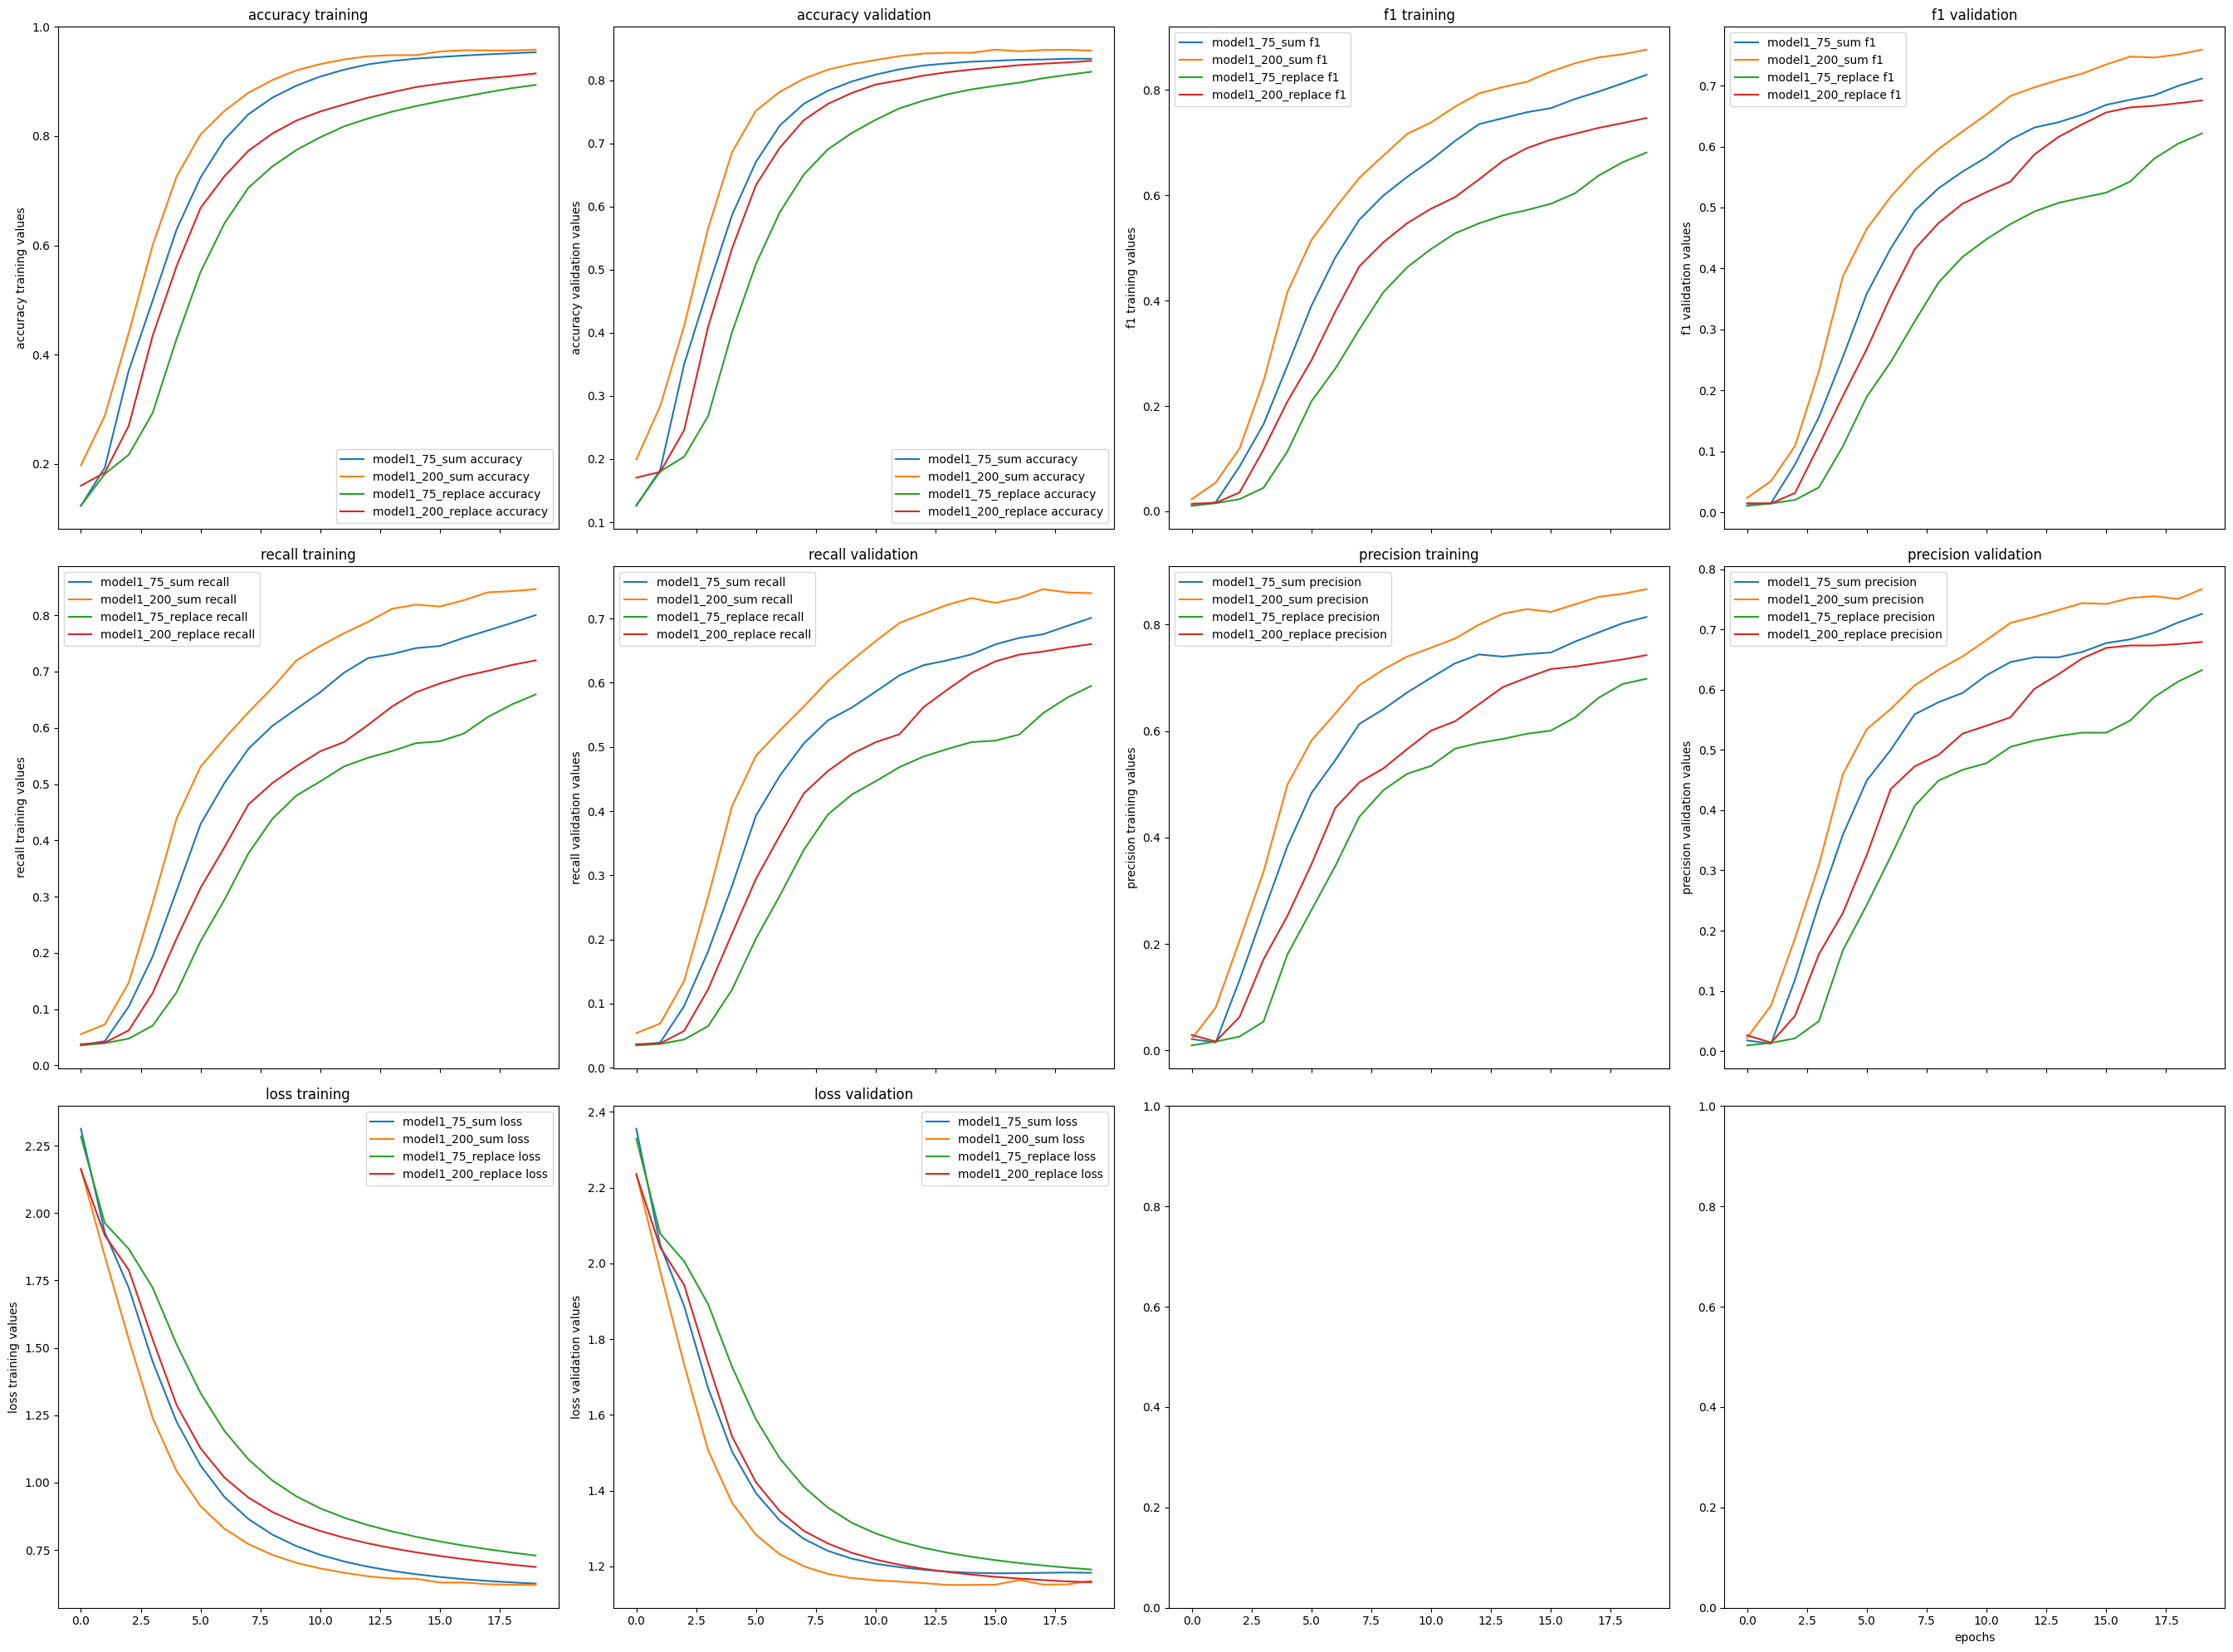

the model model1_75_sum f1 scored 0.828599054454217 on metric f1 training
the model model1_200_sum f1 scored 0.8763145959249852 on metric f1 training
the model model1_75_replace f1 scored 0.6811510996678231 on metric f1 training
the model model1_200_replace f1 scored 0.7465320488799475 on metric f1 training
the model model1_75_sum f1 scored 0.7115199663508933 on metric f1 validation
the model model1_200_sum f1 scored 0.7589695451093421 on metric f1 validation
the model model1_75_replace f1 scored 0.6214469830347819 on metric f1 validation
the model model1_200_replace f1 scored 0.6756073741659554 on metric f1 validation


In [50]:
plot_names = list(results_model1[0]['train_score'].keys())
plots = get_plots(results_model1, SEED, plot_names)
plot_dictionary_lines(plots, 'epochs',x_multiplier=5, y_multiplier=9)
for plot in ['f1 training', 'f1 validation']:
    for model in plots[plot].keys():
        print(f"the model {model} scored {plots[plot][model][-1]} on metric {plot}")

### Model 2 performances

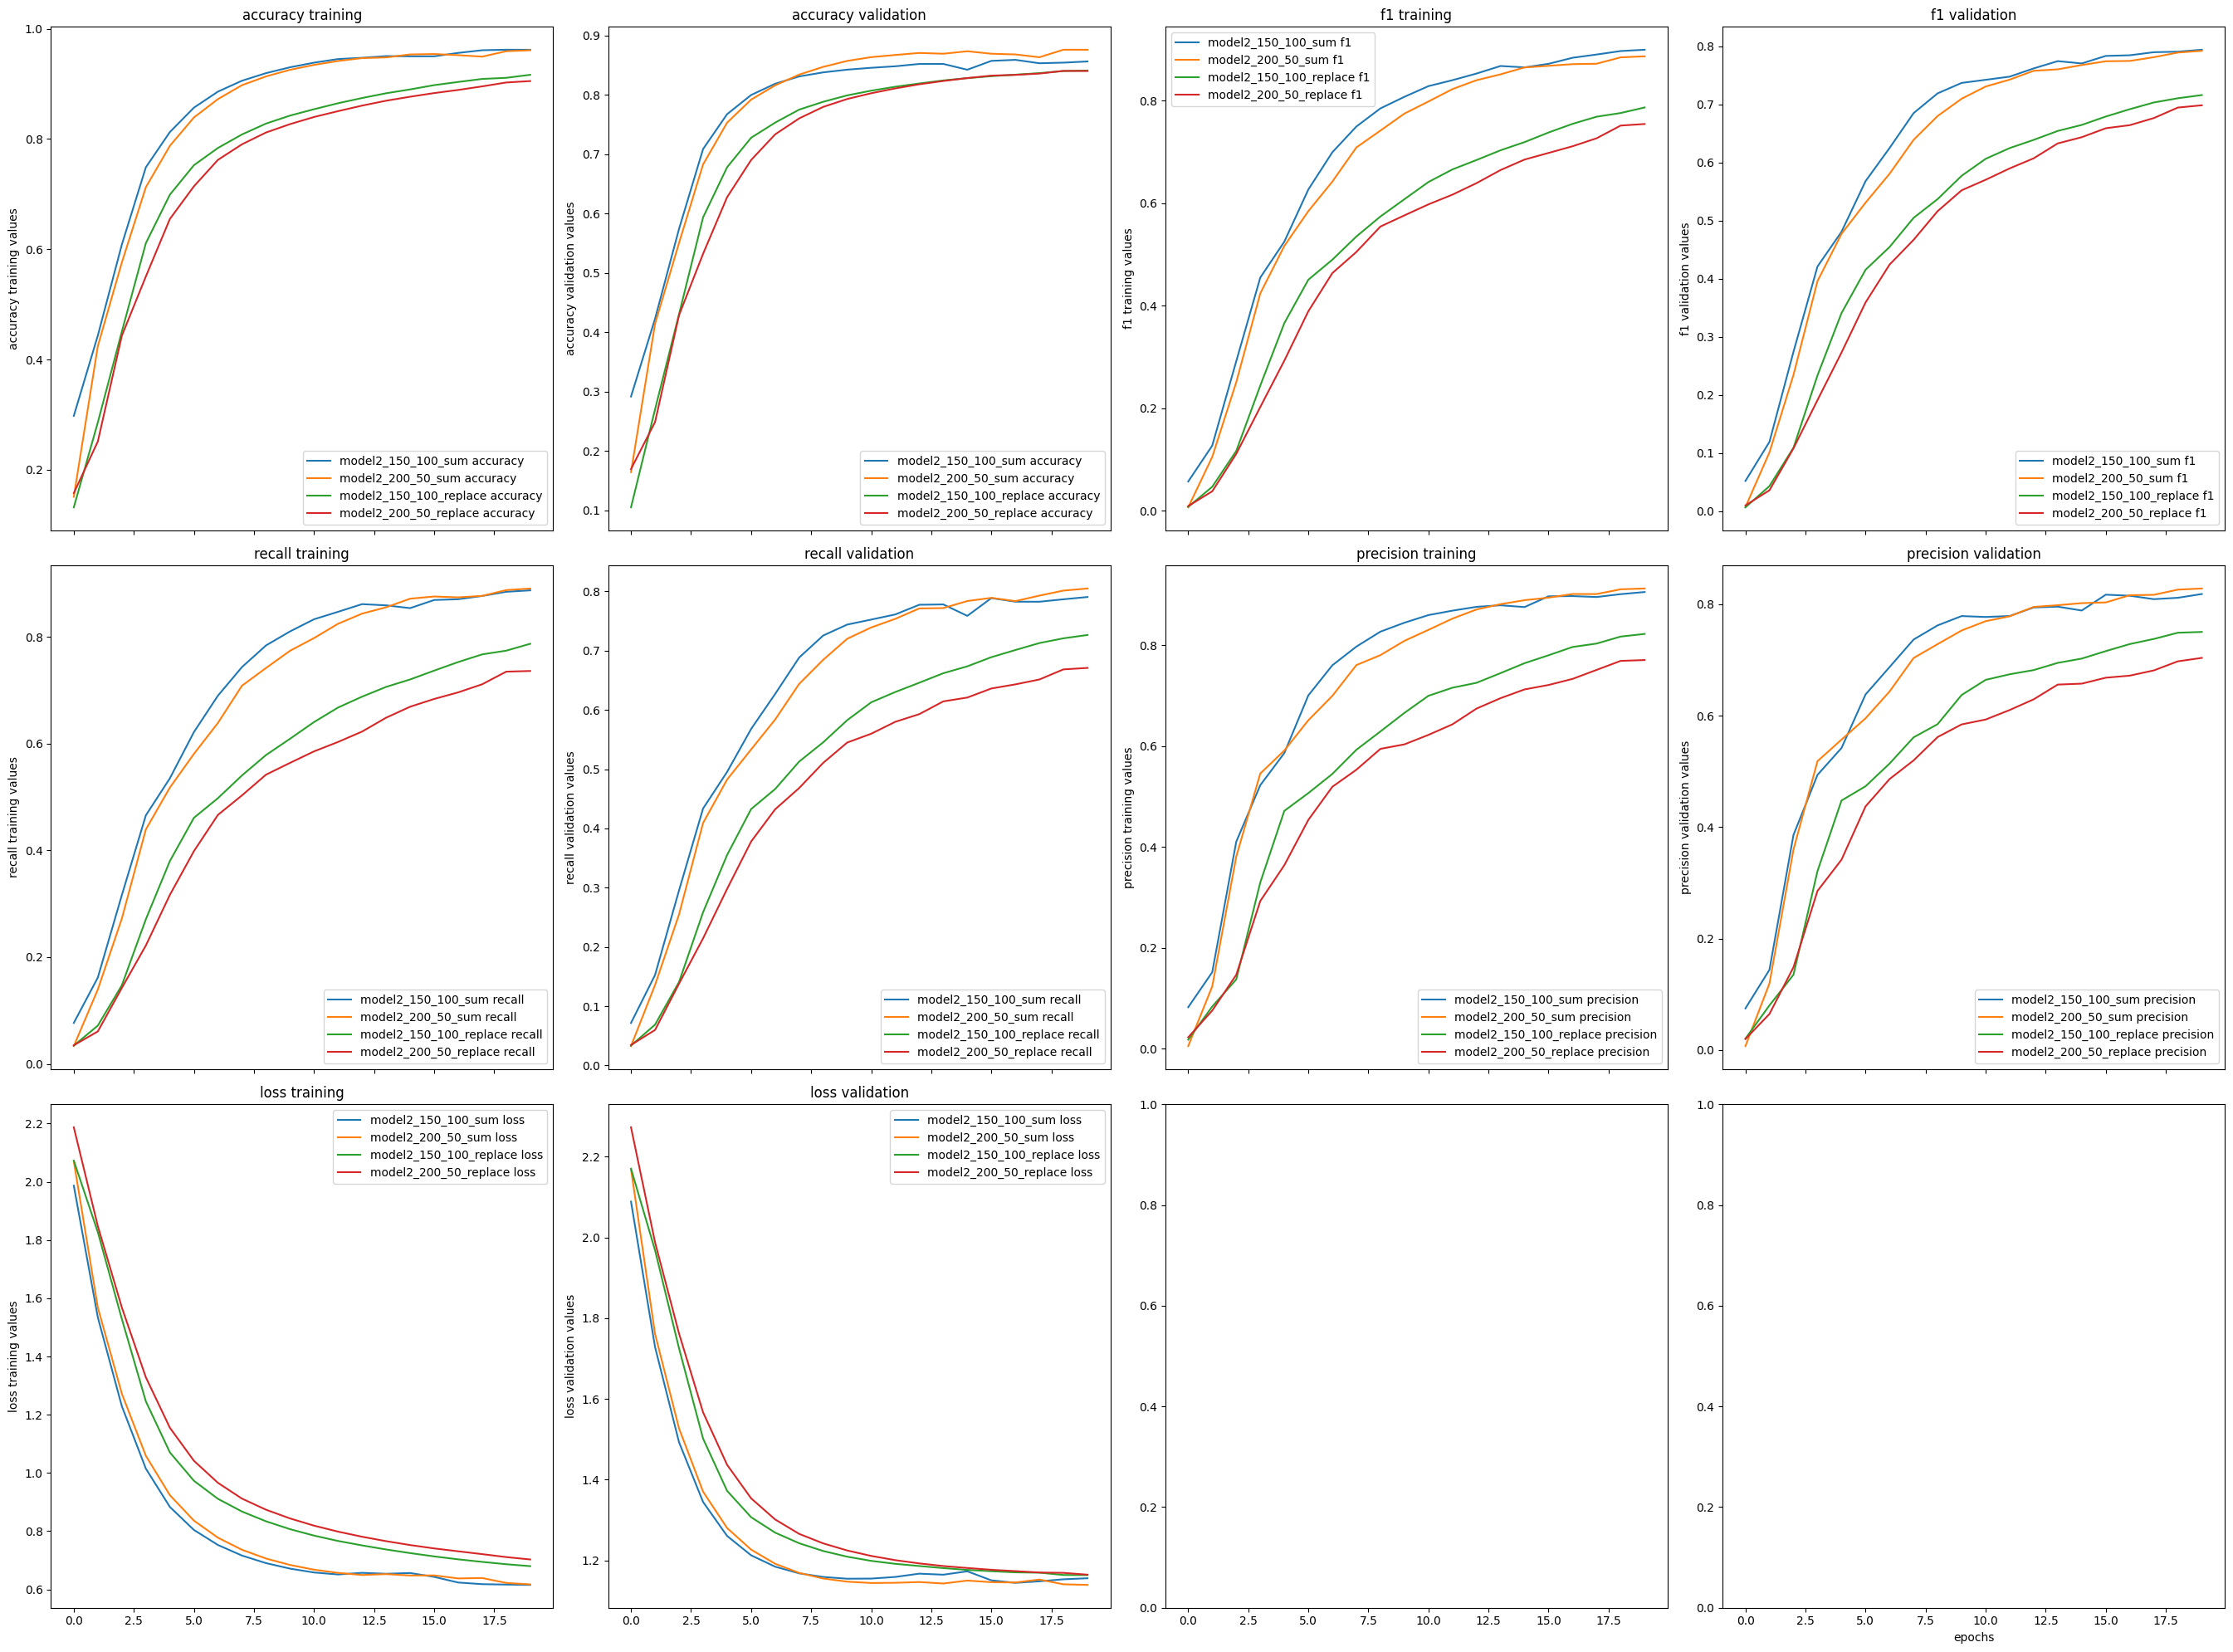

the model model2_150_100_sum f1 scored 0.8997389199087048 on metric f1 training
the model model2_200_50_sum f1 scored 0.8868804290003639 on metric f1 training
the model model2_150_100_replace f1 scored 0.7870184398159026 on metric f1 training
the model model2_200_50_replace f1 scored 0.7547558232928153 on metric f1 training
the model model2_150_100_sum f1 scored 0.7941525543574411 on metric f1 validation
the model model2_200_50_sum f1 scored 0.7922895703956536 on metric f1 validation
the model model2_150_100_replace f1 scored 0.7160947233810597 on metric f1 validation
the model model2_200_50_replace f1 scored 0.6984992126187171 on metric f1 validation


In [82]:
plot_names = list(results_model2[0]['train_score'].keys())
plots = get_plots(results_model2, SEED, plot_names)
plot_dictionary_lines(plots, 'epochs',x_multiplier=5, y_multiplier=9)
for plot in ['f1 training', 'f1 validation']:
    for model in plots[plot].keys():
        print(f"the model {model} scored {plots[plot][model][-1]} on metric {plot}")

## Best models 

In [83]:
all_models = all(results_model1, lambda e: e['name'] == 'model1_200_sum' and e["seed"] == SEED) +\
    all(results_model2, lambda e: e['name'] == 'model2_150_100_sum' and e["seed"] == SEED) +\
    all(results_baseline, lambda e: e['name'] == 'baseline_200_sum' and e["seed"] == SEED)

plots = {}
for plot_name in plot_names:
        plots[plot_name + ' training'] = {f'{model["name"]}': model['train_score'][plot_name] for model in all_models}
        plots[plot_name + ' validation']= {f'{model["name"]}': model['val_score'][plot_name] for model in all_models}
plot_dictionary_lines(plots, 'epochs',x_multiplier=5, y_multiplier=9)

In [84]:
maxes = []
for model in all_models:
    m = max(model["val_score"]["f1"])
    epochs = model["val_score"]["f1"].index(m) + 1
    maxes.append((model["name"], m, epochs))
    
maxes = sorted(maxes, key= lambda x: x[1], reverse=True)
max_score = maxes[0]
epochs = max_score[2]

In [85]:
print("model ranked by their f1 score:")
for i, max_val in enumerate(maxes):
    print(f"{i+1}) model: {max_val[0]}, score: {'{:1.3f}'.format(max_val[1])}, epochs: {max_val[2]}")

model ranked by their f1 score:
1) model: model2_150_100_sum, score: 0.794, epochs: 20
2) model: baseline_200_sum, score: 0.789, epochs: 20
3) model: model1_200_sum, score: 0.759, epochs: 20


In [44]:
best_model_parameters = {
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':150,
        'linear_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    }
random.seed(SEED)
torch.manual_seed(SEED)
best_model = Model2(**best_model_parameters)
best_model.train_network(train_loader,validation_loader,
    device=device, 
    loss_function=Custom_crossentropy(weights), 
    metrics={'accuracy':masked_accuracy, 'f1':masked_f1_score, 'recall': masked_recall, 'precision': masked_precision},
    learning_rate=.001,
    output_extraction_function=lambda x: torch.max(x, -1)[1].view(-1).cpu(),
    epochs=20,
    verbose=True
);

EPOCH 1 training loss: 1.9867823123931885 - validation loss: 2.0888235569000244                                                                                                                                                                                                                                                                                                                                                                                                                                                              
EPOCH 1 training accuracy: 0.29768414492010725 - validation accuracy: 0.2918961896344074
EPOCH 1 training f1: 0.05685256049523832 - validation f1: 0.05188659123684521
EPOCH 1 training recall: 0.07668693934122053 - validation recall: 0.07171272887000979
EPOCH 1 training precision: 0.08213248313928602 - validation precision: 0.0745646321351268
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss: 1.534

# Error Analysis

In [45]:
x_test, y_test = transform_data(test_data, vocabulary, pos_encoding)

In [46]:
x_test = x_test.to(device)
x_validation = x_validation.to(device)
best_model = best_model.to(device)

In [47]:
with torch.no_grad():
    validation_prediction = best_model(x_validation)
    test_prediction = best_model(x_test)

In [48]:
extraction_function = lambda x: torch.max(x, -1)[1].cpu()
cat_validation_prediction = extraction_function(validation_prediction)
y_validation_true = extraction_function(y_validation)
cat_test_prediction = extraction_function(test_prediction)
y_test_true = extraction_function(y_test)

In [50]:
def get_errors(y_true: torch.Tensor, 
               y_pred: torch.Tensor, 
               n_errors: int, 
               error_token: int, 
               converter: 'One_hot_encoder|None' = None) -> list[dict[str, Union[list[int], list[str], int]]]:
    """
    Identify and retrieve mismatches between true and predicted sequences.

    Parameters:
    - y_true (torch.Tensor): True sequences represented as a 2D tensor.
    - y_pred (torch.Tensor): Predicted sequences represented as a 2D tensor.
    - n_errors (int): Number of errors to retrieve.
    - error_token (int): Token value indicating an error in the sequences.
    - converter ('One_hot_encoder|None', optional): An optional converter object for translating token indices to part of speach.
      Defaults to None.

    Returns:
    List[Dict[str, Union[List[int], List[str], int]]]: A list of dictionaries containing information about identified errors.
      Each dictionary has the following keys:
        - "true": List of true sequence elements or their corresponding positions if converter is provided.
        - "pred": List of predicted sequence elements or their corresponding positions if converter is provided.
        - "idx": Index of the error in the input sequences.

    Note:
    If n_errors errors are found, the function returns the list of errors immediately. Otherwise, it returns all identified errors.
    """
    errors = []
    for i in range(y_true.shape[0]):
        y_true_line = y_true[i, :]
        y_pred_line = y_pred[i, :]
        if len(y_true_line[y_true_line == error_token]) != len(y_pred_line[y_pred_line == error_token]):
            if not converter is None:
                errors.append({
                    "true": [converter.idx2pos[t] for t in y_true_line],
                    "pred": [converter.idx2pos[t] for t in y_pred_line],
                    "idx" : i
                })
            else:
                errors.append({
                    "true": y_true_line,
                    "pred": y_pred_line,
                    "idx" : i
                })
            if len(errors) == n_errors:
                return errors
    return errors


In [51]:
print(f'accuracy on test set: {masked_accuracy(cat_test_prediction, y_test_true)}')
print(f'f1 on test set: {masked_f1_score(cat_test_prediction, y_test_true)}')
print(f'recall on test set: {masked_recall(cat_test_prediction, y_test_true)}')
print(f'precision on test set: {masked_precision(cat_test_prediction, y_test_true)}')

accuracy on test set: 0.8676341890315052
f1 on test set: 0.7933656310185947
recall on test set: 0.7669690739032875
precision on test set: 0.8098577197713355


In [52]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, fig_size =(8, 6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, without Normalization'

    # Convert PyTorch tensors to NumPy arrays
    y_true_np = y_true.cpu().numpy() if torch.is_tensor(y_true) else np.array(y_true)
    y_pred_np = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else np.array(y_pred)
    unique_labels = np.unique(np.concatenate([y_true_np, y_pred_np]))
    num_classes = len(unique_labels)
    # Compute confusion matrix
    cm = confusion_matrix(y_true_np, y_pred_np)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    # Plot the confusion matrix
    plt.figure(figsize=fig_size)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap, 
                xticklabels=[classes[unique_labels[i]] for i in range(num_classes)], 
                yticklabels=[classes[unique_labels[i]] for i in range(num_classes)])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

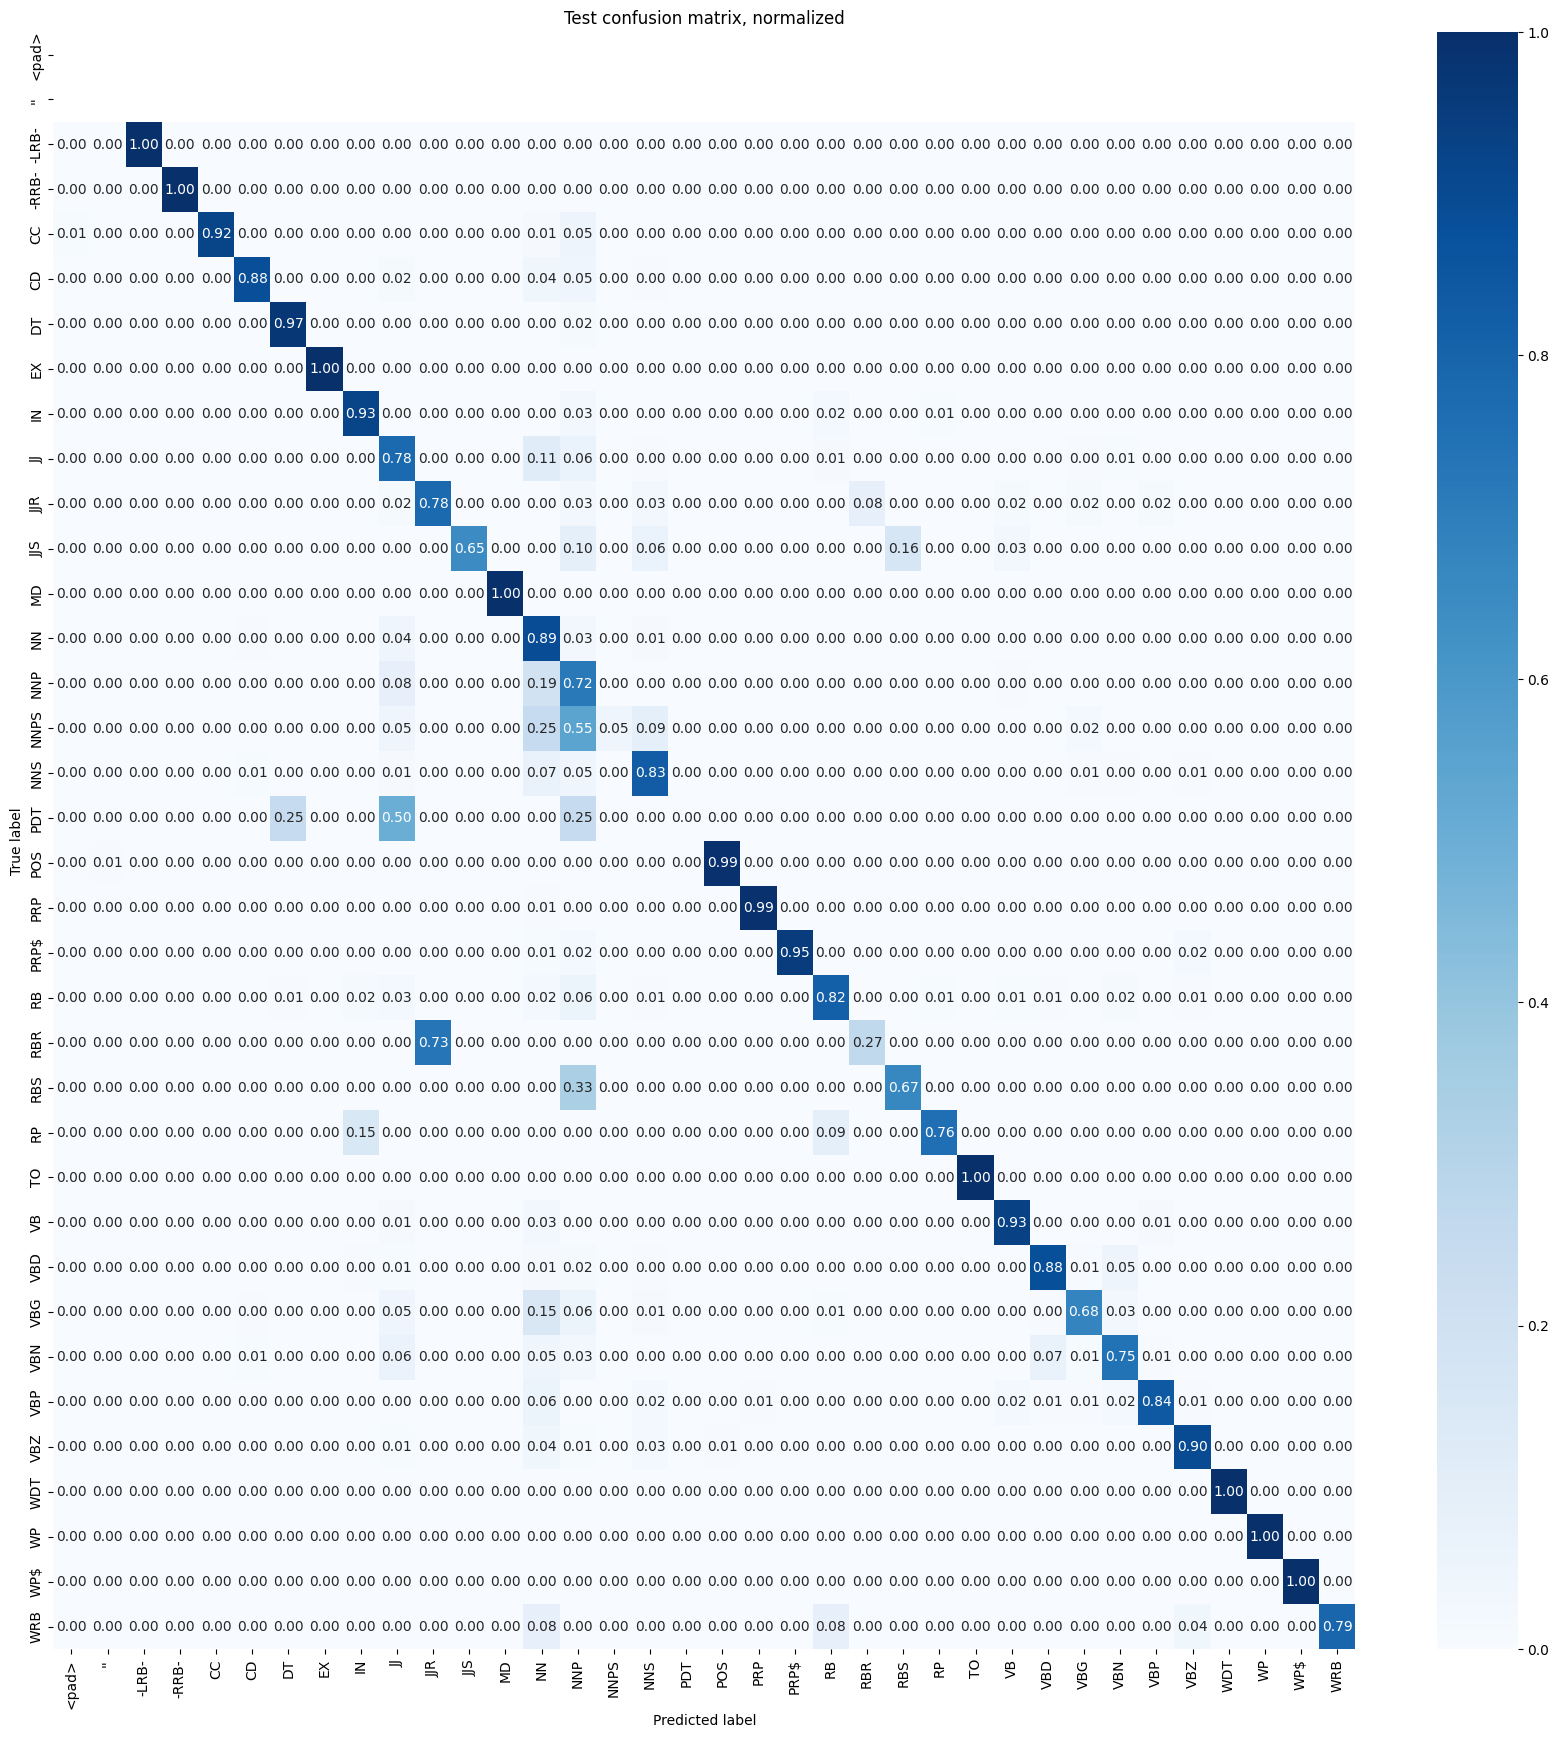

In [53]:
masked_cat_test_prediction, masked_y_test_true = mask(cat_test_prediction, y_test_true)
encoding = [pos_encoding.idx2pos[y] for y in masked_y_test_true]
plot_confusion_matrix(masked_y_test_true, masked_cat_test_prediction, pos_encoding.idx2pos, normalize=True, fig_size=(21,21), title="Test confusion matrix, normalized")

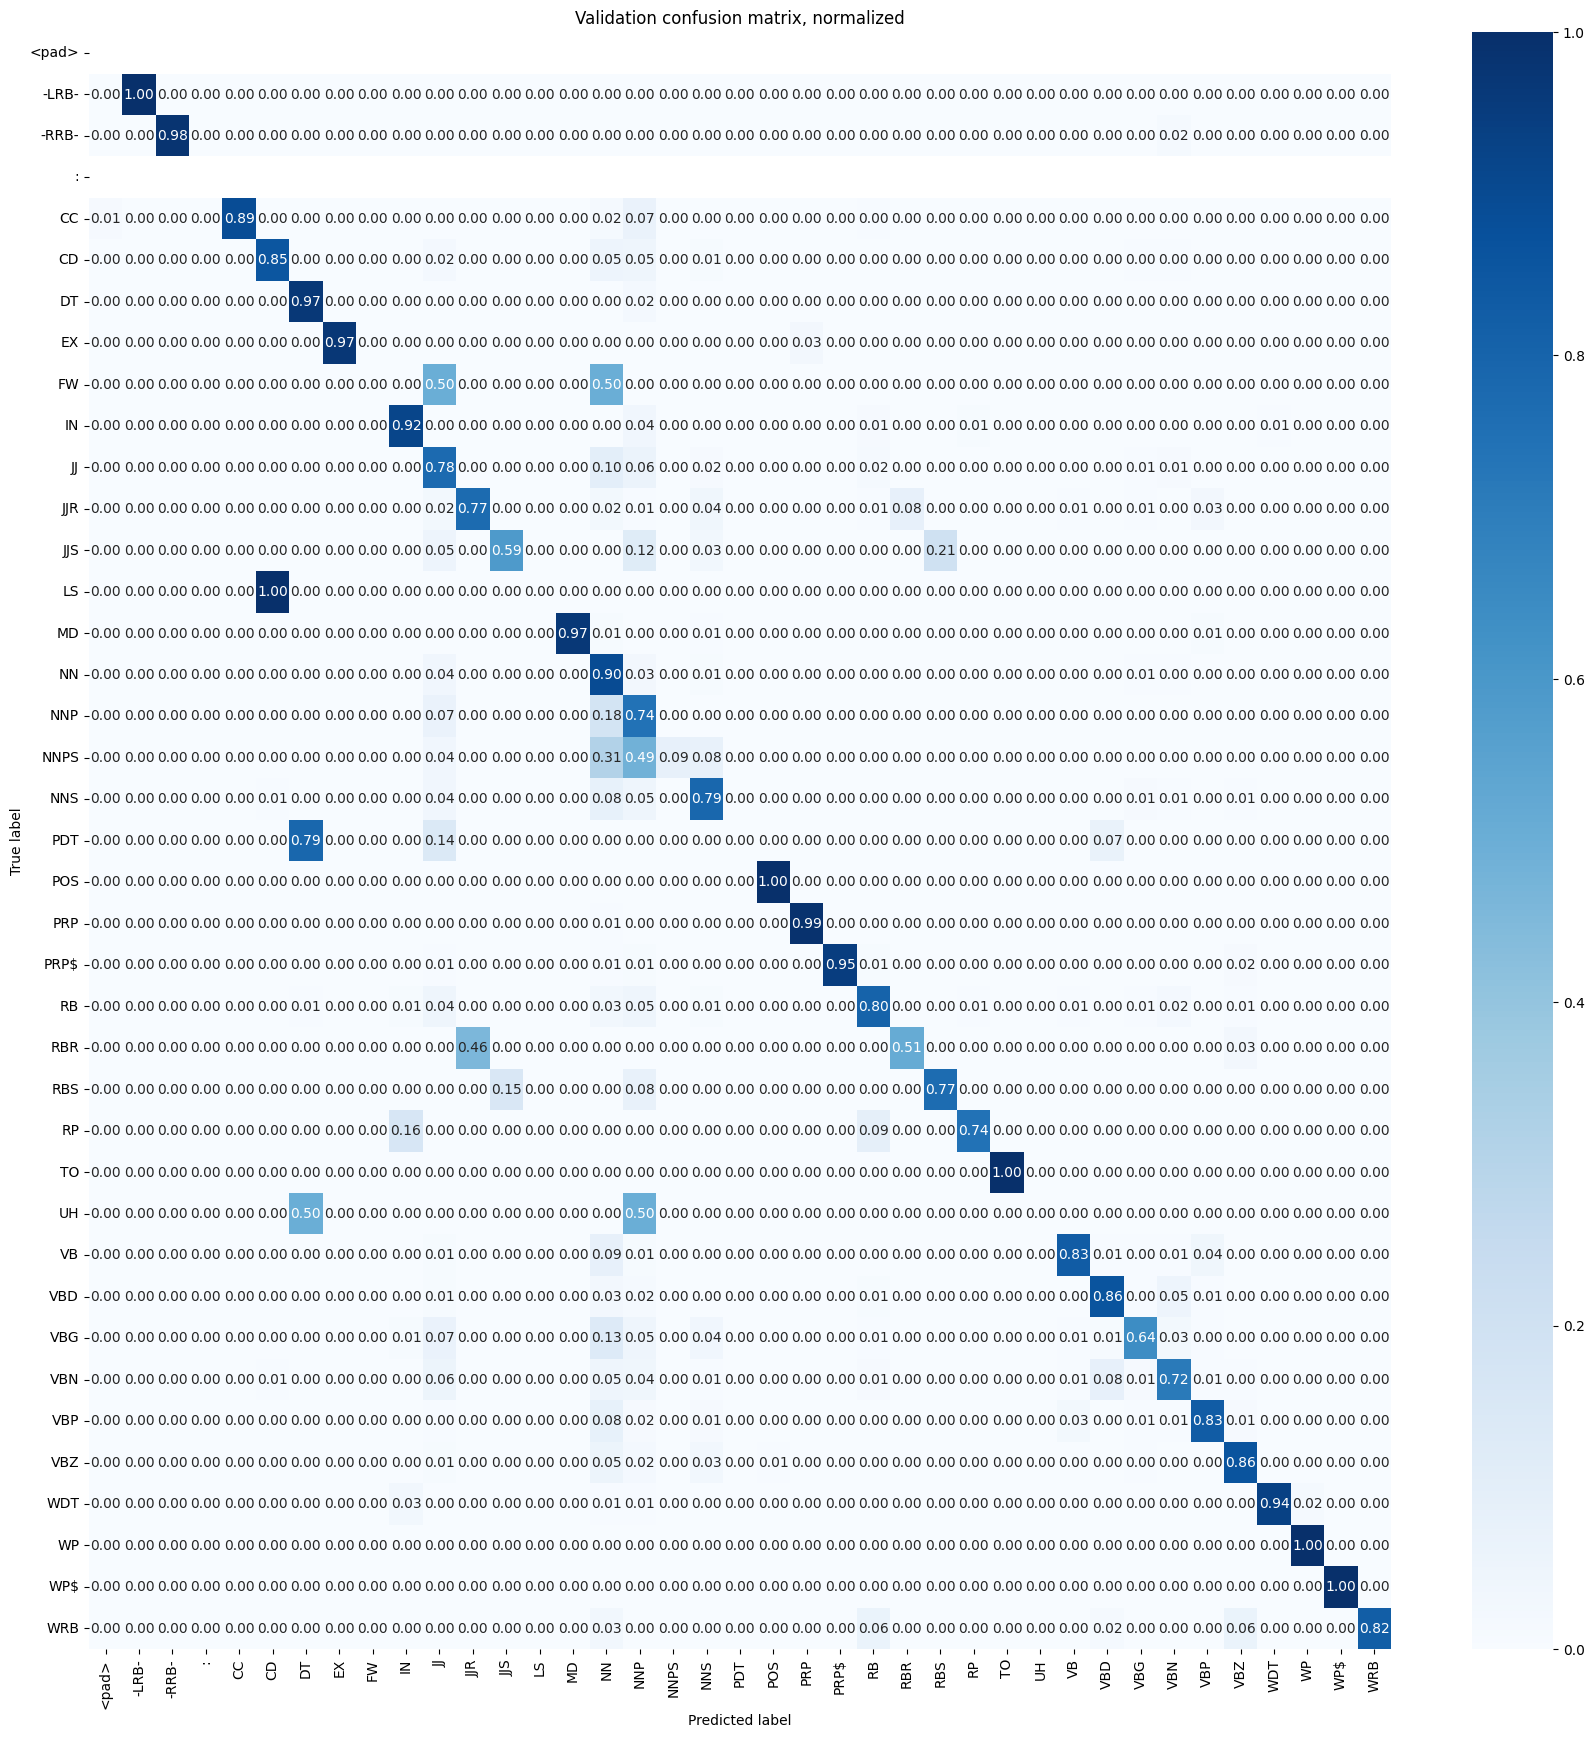

In [54]:
masked_cat_validation_prediction, masked_y_validation_true = mask(cat_validation_prediction, y_validation_true)
plot_confusion_matrix(masked_y_validation_true, masked_cat_validation_prediction, pos_encoding.idx2pos, normalize=True, fig_size=(21,21), title="Validation confusion matrix, normalized")

In [60]:
test_labels =  np.unique(y_test_true)
valdation_labels =  np.unique(y_validation_true)
test_unique_labels = np.unique(np.concatenate([masked_y_test_true, masked_cat_test_prediction]))
validation_unique_labels = np.unique(np.concatenate([masked_y_validation_true, masked_cat_validation_prediction]))

In [61]:
test_matrix = confusion_matrix(masked_y_test_true, masked_cat_test_prediction, normalize='true')
validation_matrix = confusion_matrix(masked_y_validation_true, masked_cat_validation_prediction, normalize='true')

test_correct = [(test_matrix[i,i], pos_encoding.idx2pos[test_unique_labels[i]]) for i in range(test_matrix.shape[0])]
test_correct.sort(reverse=True, key= lambda x: x[0])
validation_correct = [(validation_matrix[i,i], pos_encoding.idx2pos[validation_unique_labels[i]]) for i in range(validation_matrix.shape[0])]
validation_correct.sort(reverse=True, key= lambda x: x[0])

In [63]:
for i in reversed(range(len(test_correct))):
    if not pos_encoding.pos2idx[test_correct[i][1]] in np.unique(masked_y_test_true):
        test_correct.pop(i)

print("The most errors on the test set have been done on the classes:")
for i in range(1, 11):
    print(f"{i}) {test_correct[-i][1]} with {'{:1.2f}'.format((1 - test_correct[-i][0]) * 100)}% of wrong values")

The most errors on the test set have been done on the classes:
1) PDT with 100.00% of wrong values
2) NNPS with 95.45% of wrong values
3) RBR with 73.33% of wrong values
4) JJS with 35.48% of wrong values
5) RBS with 33.33% of wrong values
6) VBG with 32.13% of wrong values
7) NNP with 28.06% of wrong values
8) VBN with 25.41% of wrong values
9) RP with 24.24% of wrong values
10) JJR with 22.03% of wrong values


In [64]:
train_len = len(train_data)
for i in range(1, 11):
    pos = test_correct[-i][1]
    pos_data_count, pos_data_unk, tot_pos = 0,0,0
    for j in range(train_data.shape[0]):
        row = train_data.iloc[j, :]
        if row['pos label'] == pos:
            pos_data_count +=1
    for j in range(test_data.shape[0]):
        row = test_data.iloc[j, :]
        if row['pos label'] == pos:
            tot_pos += 1
            if vocabulary.word2idx(row['word/symbol']) == 0:
               pos_data_unk +=1
    sentence = f"there are {pos_data_count} occurrences of pos {pos} in the train data ({'{:1.2f}'.format((pos_data_count / train_len) * 100)}%). {pos_data_unk} over {tot_pos} occurrences ({'{:1.2f}'.format((pos_data_unk / tot_pos) * 100)}%) of pos in the test set are unknown words"
    print(sentence)
    print(len(sentence) * "-")

there are 9 occurrences of pos PDT in the train data (0.02%). 0 over 4 occurrences (0.00%) of pos in the test set are unknown words
-----------------------------------------------------------------------------------------------------------------------------------
there are 95 occurrences of pos NNPS in the train data (0.20%). 16 over 44 occurrences (36.36%) of pos in the test set are unknown words
----------------------------------------------------------------------------------------------------------------------------------------
there are 86 occurrences of pos RBR in the train data (0.18%). 0 over 15 occurrences (0.00%) of pos in the test set are unknown words
-------------------------------------------------------------------------------------------------------------------------------------
there are 93 occurrences of pos JJS in the train data (0.20%). 0 over 31 occurrences (0.00%) of pos in the test set are unknown words
------------------------------------------------------------

In [76]:
n_error = 3
for i in range(1, 11):
    pos = test_correct[-i][1]
    errors = get_errors(y_test_true, cat_test_prediction, n_error, pos_encoding.pos2idx[pos], pos_encoding)
    print("-"*20)
    print(f"pos: {pos}")
    i = 0
    for error in errors:
        idx = error['idx']
        sentence = [vocabulary.idx2word[token] for token in x_test[idx, :]]
        print(f"{i} sentence: {' '.join(all(sentence, lambda x: x != '<pad>'))}")
        print(f"{i} true pos values: {' '.join(all(error['true'], lambda x: x != '<pad>'))}")
        print(f"{i} pred pos values: {' '.join(all(error['pred'], lambda x: x != '<pad>'))}")
        print()

--------------------
pos: PDT
0 sentence: But it is n't clear yet whether the central bank will make such a move .
0 true pos values: CC PRP VBZ RB JJ RB IN DT JJ NN MD VB PDT DT NN .
0 pred pos values: NNP PRP VBZ RB JJ RB IN DT JJ NN MD VB JJ DT NN .

0 sentence: All this has cast a pall over Columbia Savings & Loan Association and its <unk> 43-year-old chairman , Thomas <unk> , who built the $ 12.7 billion Beverly Hills , Calif. , thrift with high-yield junk bonds .
0 true pos values: PDT DT VBZ VBN DT NN IN NNP NNPS CC NNP NNP CC PRP$ JJ JJ NN , NNP NNP , WP VBD DT $ CD CD NNP NNP , NNP , NN IN JJ NN NNS .
0 pred pos values: NNP DT VBZ VBN DT NNP IN NNP NNP CC NNP NNP CC PRP$ JJ NNP NN , NNP NNP , WP VBN DT $ CD CD NNP NNP , NNP , NN IN JJ JJ NNS .

0 sentence: While many problems would attend a restructuring of Columbia , investors say Mr. <unk> is mulling such a plan to mitigate Columbia 's junk problems .
0 true pos values: IN JJ NNS MD VB DT NN IN NNP , NNS VBP NNP NNP VBZ VBG 

In [66]:
for i in reversed(range(len(validation_correct))):
    if not  pos_encoding.pos2idx[validation_correct[i][1]] in np.unique(masked_y_validation_true):
        removed = validation_correct.pop(i)
print("The most errors on the validation set have been done on the classes:")
for i in range(1, 11):
    print(f"{i}) {validation_correct[-i][1]} with {'{:1.2f}'.format((1 - test_correct[-i][0]) * 100)}% of wrong values")

The most errors on the validation set have been done on the classes:
1) UH with 100.00% of wrong values
2) PDT with 95.45% of wrong values
3) LS with 73.33% of wrong values
4) FW with 35.48% of wrong values
5) NNPS with 33.33% of wrong values
6) RBR with 32.13% of wrong values
7) JJS with 28.06% of wrong values
8) VBG with 25.41% of wrong values
9) VBN with 24.24% of wrong values
10) NNP with 22.03% of wrong values


In [67]:
for i in range(1, 11):
    pos = test_correct[-i][1]
    pos_data_count, pos_data_unk, tot_pos = 0,0,0
    for j in range(train_data.shape[0]):
        row = train_data.iloc[j, :]
        if row['pos label'] == pos:
            pos_data_count +=1
    for j in range(validation_data.shape[0]):
        row = validation_data.iloc[j, :]
        if row['pos label'] == pos:
            tot_pos += 1
            if vocabulary.word2idx(row['word/symbol']) == 0:
               pos_data_unk +=1
    sentence = f"there are {pos_data_count} occurrences of pos {pos} in the train data ({'{:1.2f}'.format((pos_data_count / train_len) * 100)}%). {pos_data_unk} over {tot_pos} occurrences ({'{:1.2f}'.format((pos_data_unk / tot_pos) * 100)}%) of pos in the validation set are unknown words"
    print(sentence)
    print(len(sentence) * "-")

there are 9 occurrences of pos PDT in the train data (0.02%). 0 over 14 occurrences (0.00%) of pos in the validation set are unknown words
------------------------------------------------------------------------------------------------------------------------------------------
there are 95 occurrences of pos NNPS in the train data (0.20%). 56 over 105 occurrences (53.33%) of pos in the validation set are unknown words
-----------------------------------------------------------------------------------------------------------------------------------------------
there are 86 occurrences of pos RBR in the train data (0.18%). 0 over 35 occurrences (0.00%) of pos in the validation set are unknown words
-------------------------------------------------------------------------------------------------------------------------------------------
there are 93 occurrences of pos JJS in the train data (0.20%). 0 over 58 occurrences (0.00%) of pos in the validation set are unknown words
--------------

In [78]:
n_error = 3
for i in range(1, 11):
    pos = validation_correct[-i][1]
    errors = get_errors(y_validation_true, cat_validation_prediction, n_error, pos_encoding.pos2idx[pos], pos_encoding)
    print("-"*20)
    print(f"pos: {pos}")
    i = 0
    for error in errors:
        idx = error['idx']
        sentence = [vocabulary.idx2word[token] for token in x_validation[idx, :]]
        print(f"{i} sentence: {' '.join(all(sentence, lambda x: x != '<pad>'))}")
        print(f"{i} true pos values: {' '.join(all(error['true'], lambda x: x != '<pad>'))}")
        print(f"{i} pred pos values: {' '.join(all(error['pred'], lambda x: x != '<pad>'))}")
        print()

--------------------
pos: UH
0 sentence: But New York state , which is seeking solutions to its prison cell shortage , says `` no .
0 true pos values: CC NNP NNP NN , WDT VBZ VBG NNS TO PRP$ NN NN NN , VBZ `` UH .
0 pred pos values: NNP NNP NNP NN , WDT VBZ VBG NN TO PRP$ NN NN NN , VBZ `` DT .

0 sentence: <unk> , you 're in the paper business , '' is one reaction Mr. <unk> says he 's gotten from his big institutional shareholders .
0 true pos values: UH , PRP VBP IN DT NN NN , '' VBZ CD NN NNP NNP VBZ PRP VBZ VBN IN PRP$ JJ JJ NNS .
0 pred pos values: NNP , PRP VBP IN DT NN NN , '' VBZ CD NN NNP NNP VBZ PRP VBZ NN IN PRP$ JJ JJ NNS .

--------------------
pos: PDT
0 sentence: The Bush administration has threatened to veto such a bill because of what it views as an undesirable intrusion into the affairs of industry , but the <unk> vote suggests that supporters have the potential to override a veto .
0 true pos values: DT NNP NN VBZ VBN TO VB PDT DT NN IN IN WP PRP VBZ IN DT JJ NN IN D

In [68]:
print("The classes:")
for label in np.unique(validation_data['pos label']):
    if not label in np.unique(test_data['pos label']):
        print(f'- {label}')
print("Are not present in the test set")

The classes:
- #
- FW
- LS
- UH
Are not present in the test set
